<a href="https://colab.research.google.com/github/ashwin-sanjay/special-waffle/blob/master/Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install networkx

In [8]:
import xml.etree.ElementTree as ET
import networkx as nx

# Path to your XML file
file_path = '/content/drive/MyDrive/maxed.xml'

# Parse the XML file
tree = ET.parse(file_path)
root = tree.getroot()
tree

In [48]:
from collections import deque
import xml.etree.ElementTree as ET

def bfs_find(element, tag):
    """
    Perform BFS to find the first element with the specified tag.
    Args:
        element: The starting XML element (root).
        tag: The tag to search for.
    Returns:
        The first matching element, or None if not found.
    """
    queue = deque([element])  # Start with the root in the queue

    while queue:
        current = queue.popleft()  # Dequeue the next element

        # Check if this element matches the tag
        if current.tag == tag:
            return current

        # Enqueue all child elements for further exploration
        queue.extend(list(current))

    return None  # Return None if no match is found


In [77]:
# Create an empty directed graph
G = nx.DiGraph()

# Function to recursively add subgraphs to the graph
def add_subgraph(graph, root_element):

    # Add edges from prodStepLinkCollection (with edges inside <c> elements)
    prodStepLinkCollection = bfs_find(root_element, 'prodStepLinkCollection').find('.//c')
    # print(prodStepLinkCollection.attrib)
    for edge in prodStepLinkCollection:
        source = edge.find('sourceProdStep').get('reference')  # Assuming 'source' and 'target' are attributes of ProdStepLinkVO
        target = edge.find('targetProdStep').get('reference')
        graph.add_edge(source, target)

     # Add nodes from prodStepCollection (with nodes inside <c> elements)
    prodStepCollection = bfs_find(root_element, 'prodStepCollection').find('.//c')
    # print(prodStepCollection.attrib)
    for node in prodStepCollection:
        node_id = node.get('id')  # Assuming the node has an 'id' attribute
        node_type = node.tag.split('.')[-1]  # Extract the node type from the tag
        description = node.find('description').text if node.find('description') is not None else None
        custom_id = node.find('customId').text if node.find('customId') is not None else None
        if node.find('.//prodStepCollection') is None:
          graph.add_node(node_id, type=node_type, description=description, customId=custom_id)
        else:
          subgraph = nx.DiGraph()
          add_subgraph(subgraph, node)
          graph.add_node(node_id, type=node_type, description=description, customId=custom_id, subgraph=subgraph)



# Example: Start building the graph with the root XML element
add_subgraph(G, root)

# Example of viewing the nodes and edges


def bfs_print(graph):
    queue = deque([(graph, "Parent Graph")])  # Queue holds tuples of (graph, description)

    while queue:
        current_graph, description = queue.popleft()

        print(f"\nGraph: {description}")
        print("Nodes:")
        for node_id, attributes in current_graph.nodes(data=True):
            print(f"  Node ID: {node_id}, Attributes: {attributes}")

            # If the node has a subgraph, enqueue it for further BFS
            subgraph = attributes.get('subgraph')
            if subgraph:
                queue.append((subgraph, f"Subgraph of Node {node_id}"))

        print("Edges:")
        for edge in current_graph.edges():
            print(f"  {edge}")

# Perform BFS and print all levels of the graph
bfs_print(G)


Graph: Parent Graph
Nodes:
  Node ID: 9240, Attributes: {'type': 'StartStepVO', 'description': None, 'customId': 'Start'}
  Node ID: 59, Attributes: {'type': 'BasicOperationVO', 'description': 'Buffer Prep', 'customId': '0100', 'subgraph': <networkx.classes.digraph.DiGraph object at 0x7a37684633a0>}
  Node ID: 11, Attributes: {'type': 'BasicOperationVO', 'description': 'SAP / MES Alignment BO', 'customId': '0120', 'subgraph': <networkx.classes.digraph.DiGraph object at 0x7a376830a8c0>}
  Node ID: 10, Attributes: {'type': 'EndStepVO', 'description': None, 'customId': 'End'}
Edges:
  ('9240', '59')
  ('59', '11')
  ('11', '10')

Graph: Subgraph of Node 59
Nodes:
  Node ID: 9189, Attributes: {'type': 'CommonBFVO', 'description': 'Bill of Testing', 'customId': 'CBF3', 'subgraph': <networkx.classes.digraph.DiGraph object at 0x7a373ec765f0>}
  Node ID: 7873, Attributes: {'type': 'SynchronisationVO', 'description': None, 'customId': 'Sync1'}
  Node ID: 9118, Attributes: {'type': 'CommonBFVO'

<ipython-input-86-9bb26e70a2f7>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(fig_count, figsize=(8, 6))


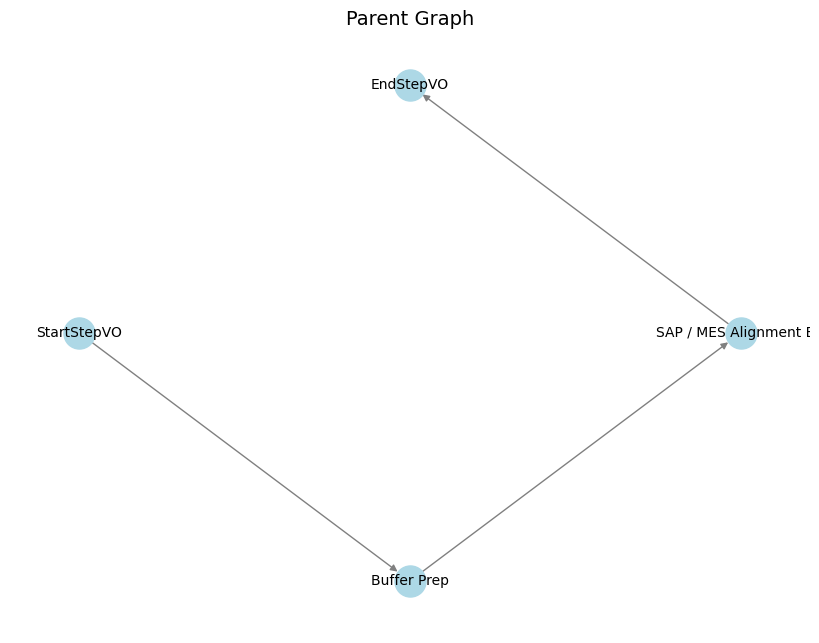

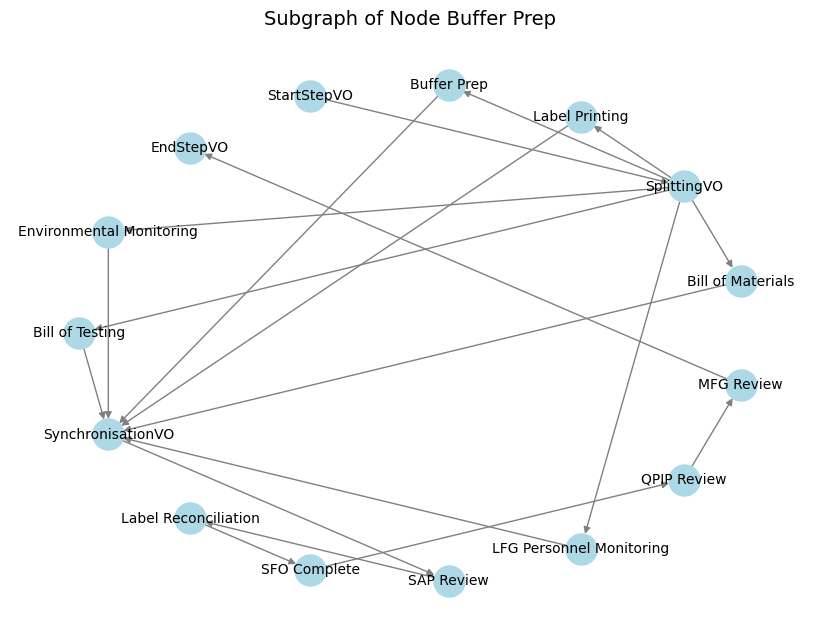

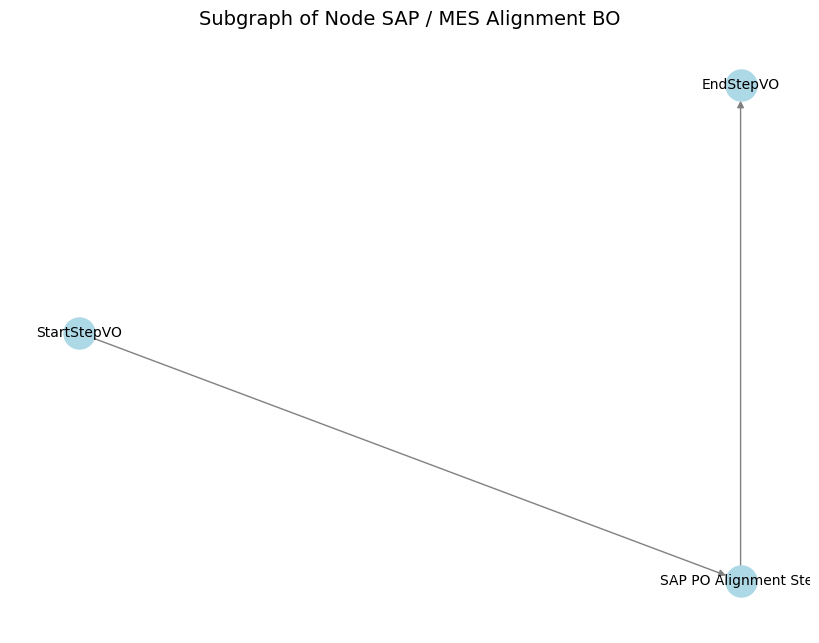

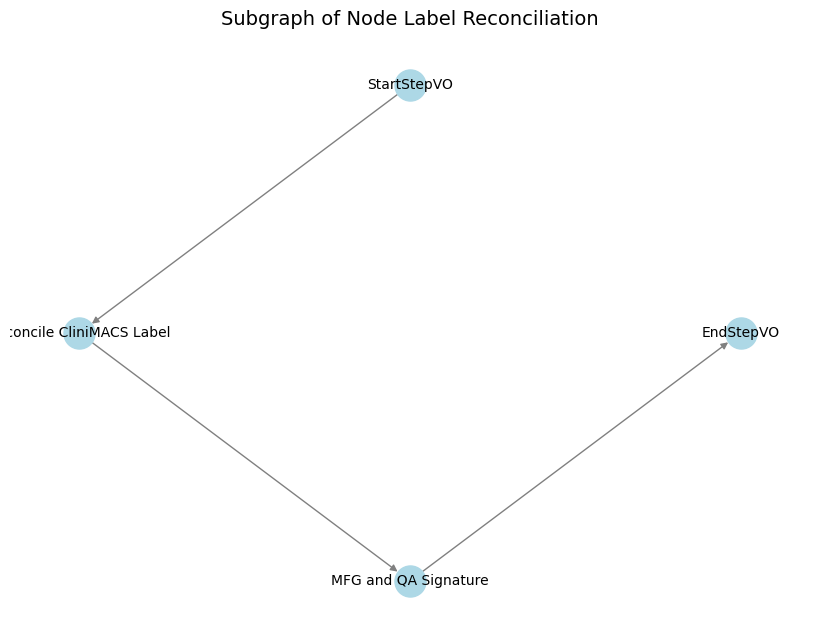

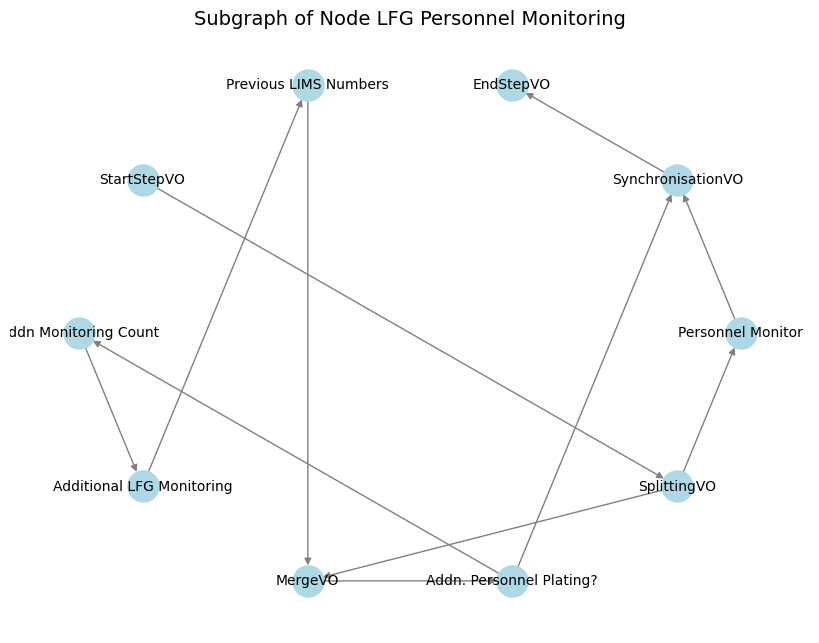

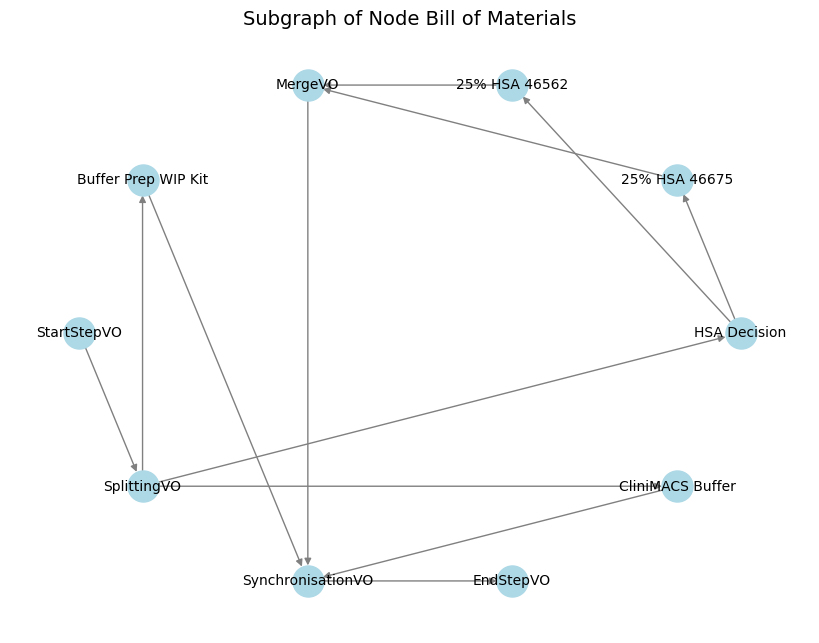

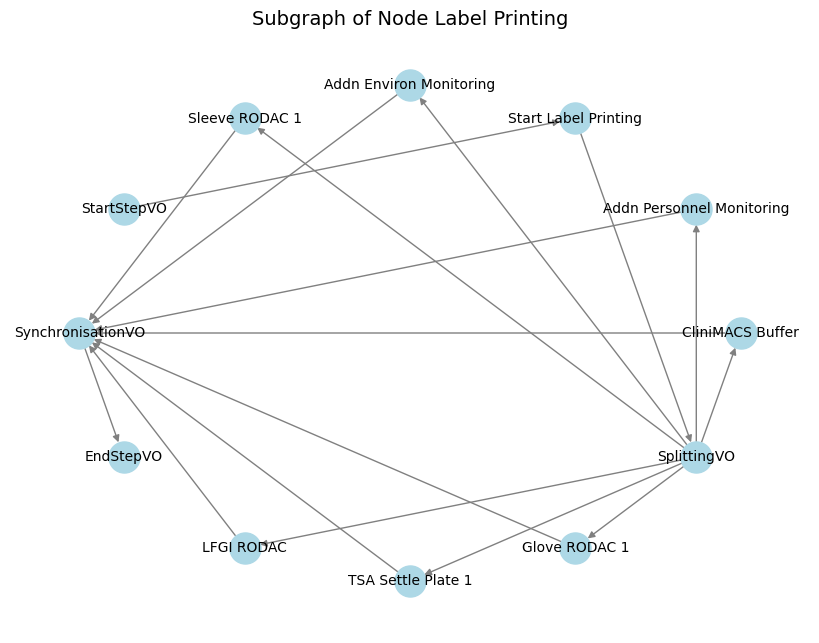

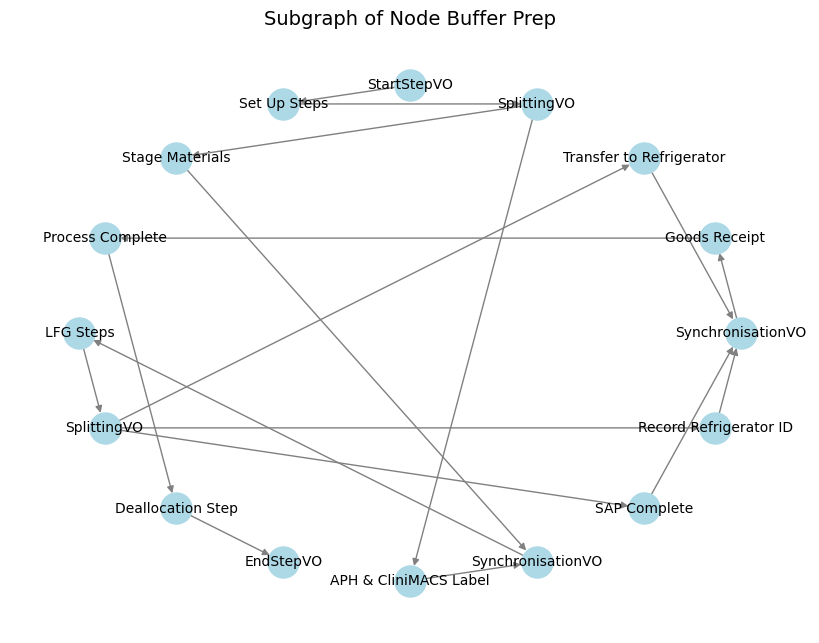

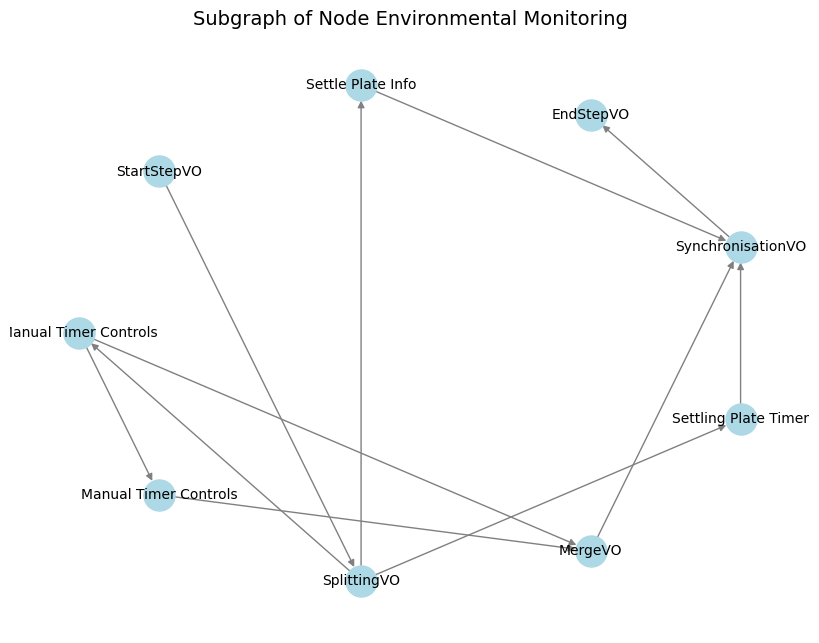

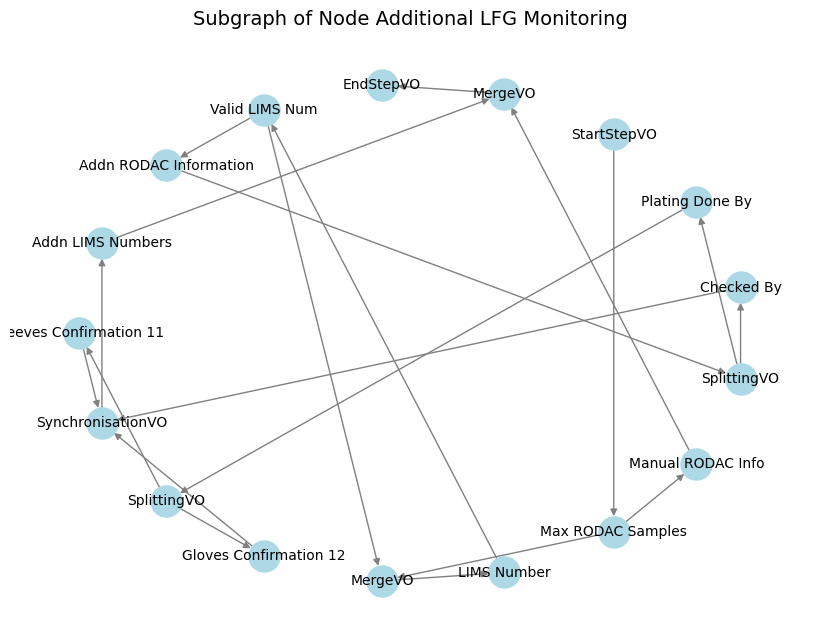

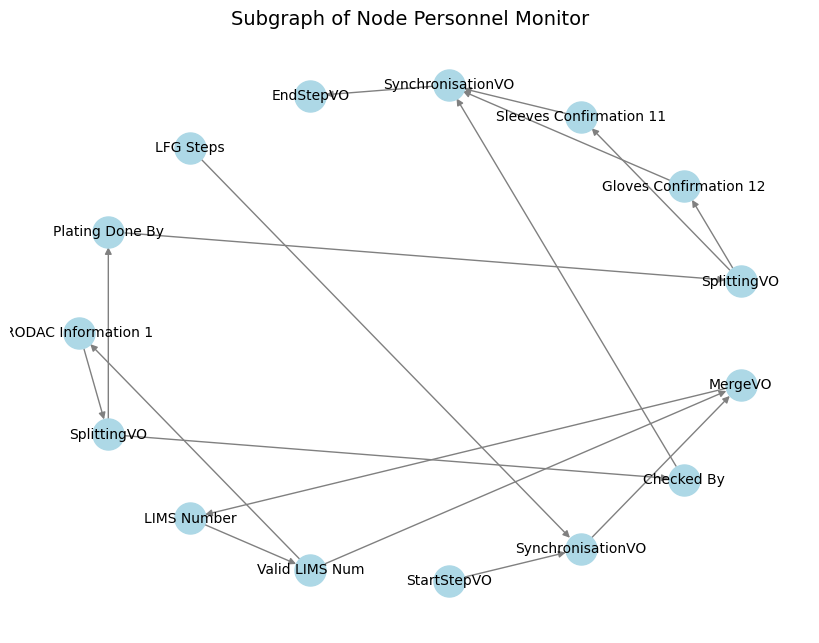

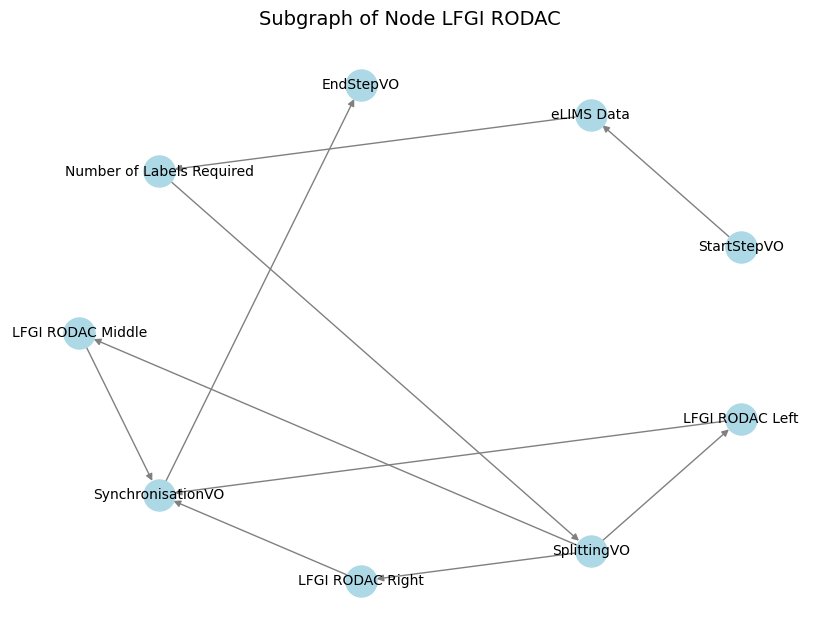

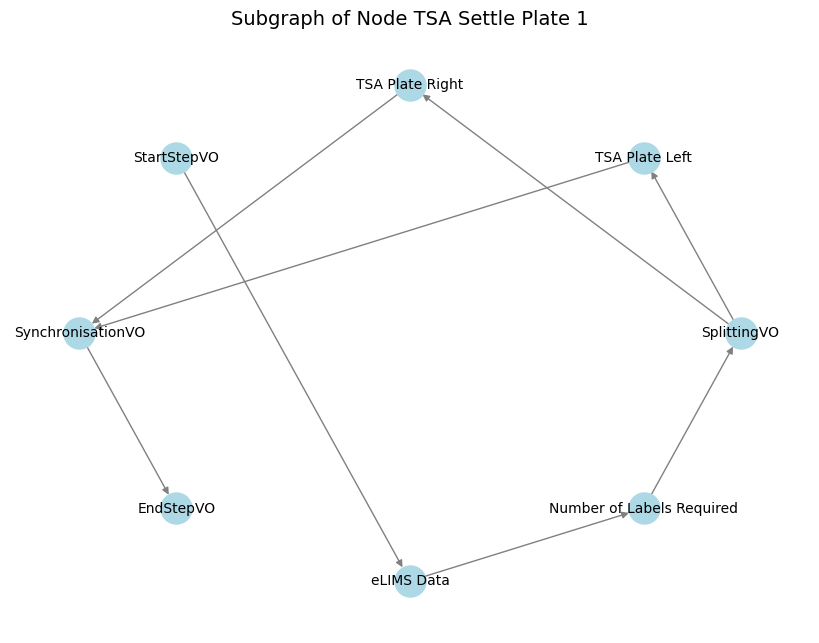

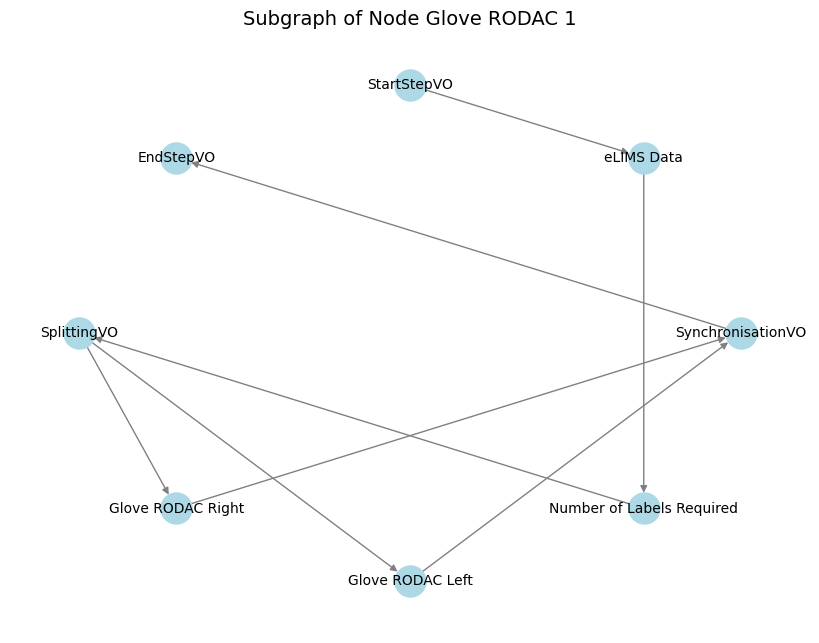

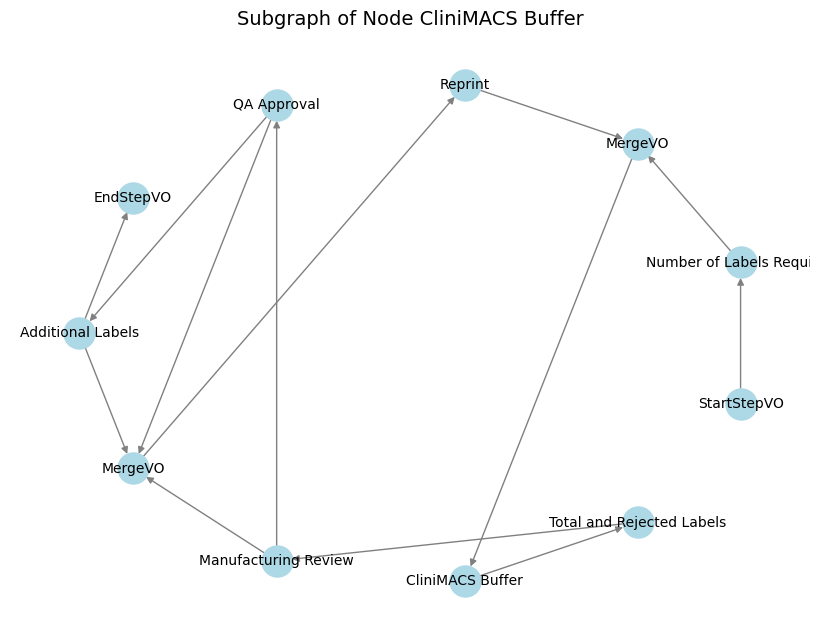

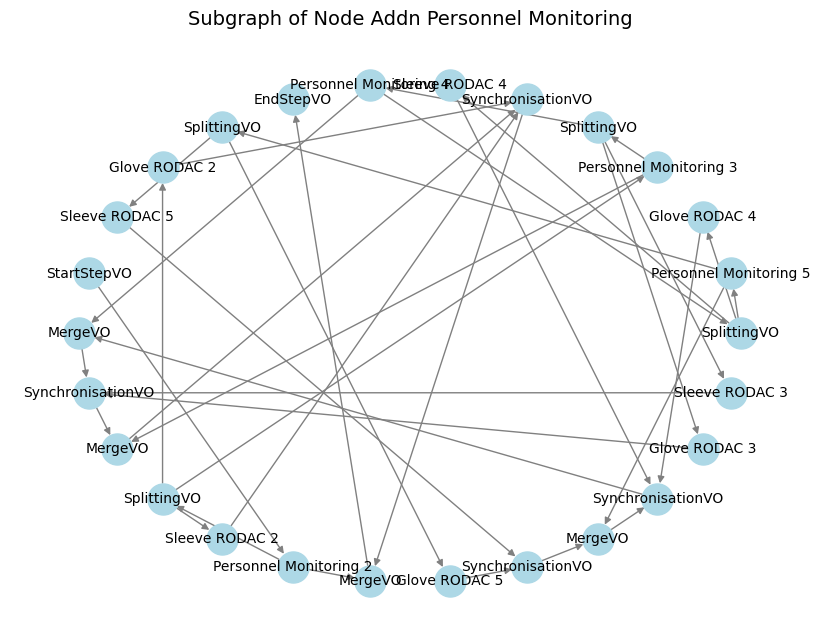

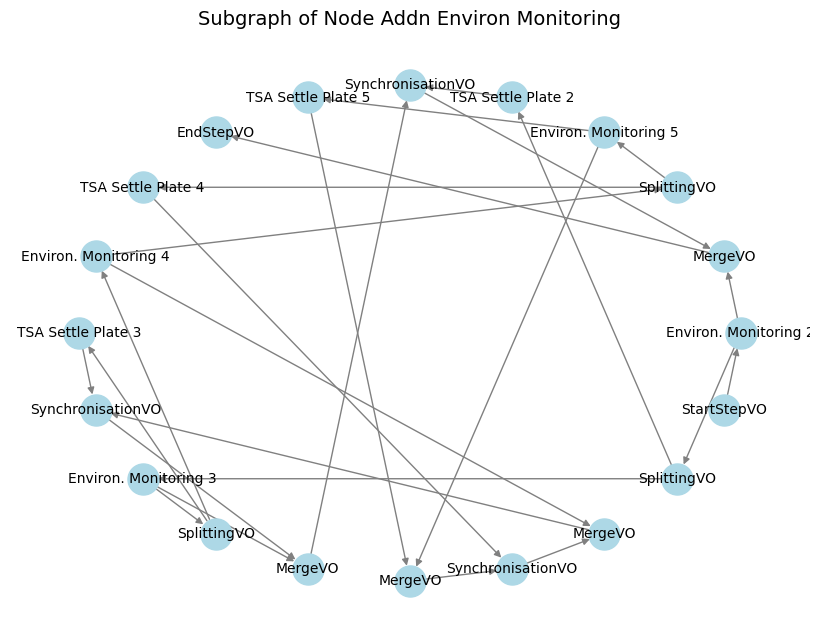

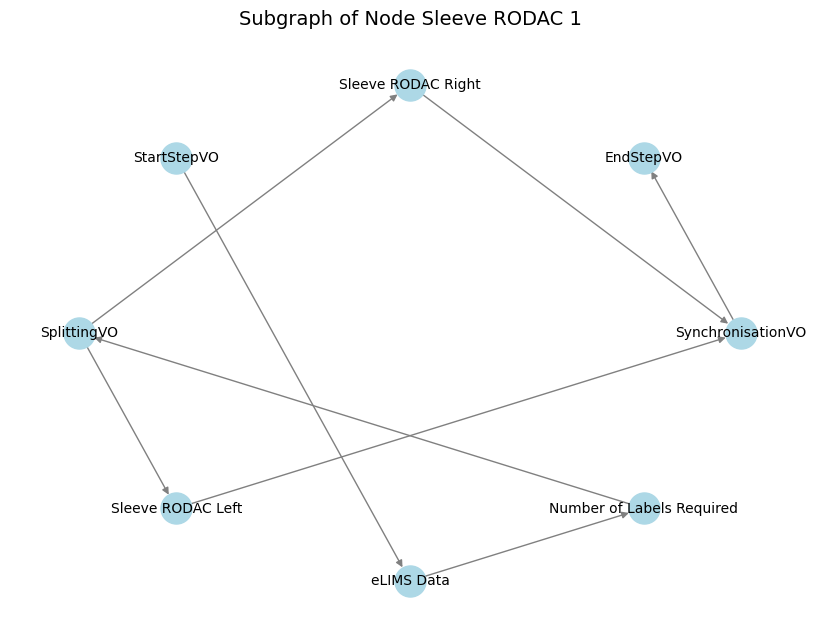

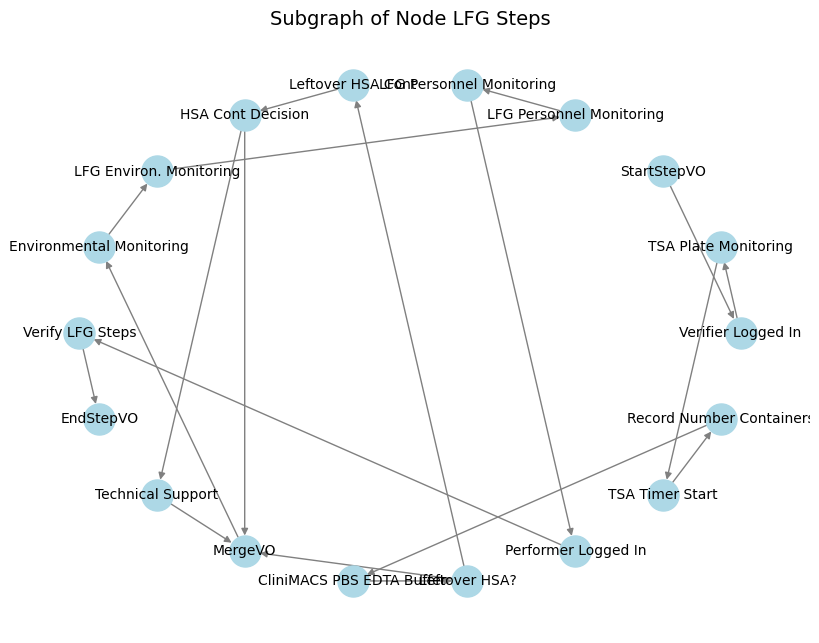

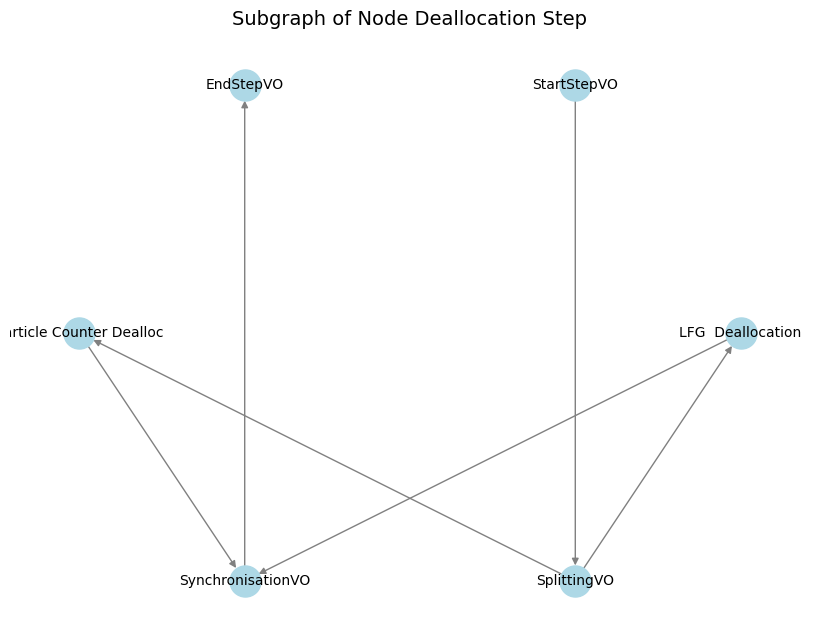

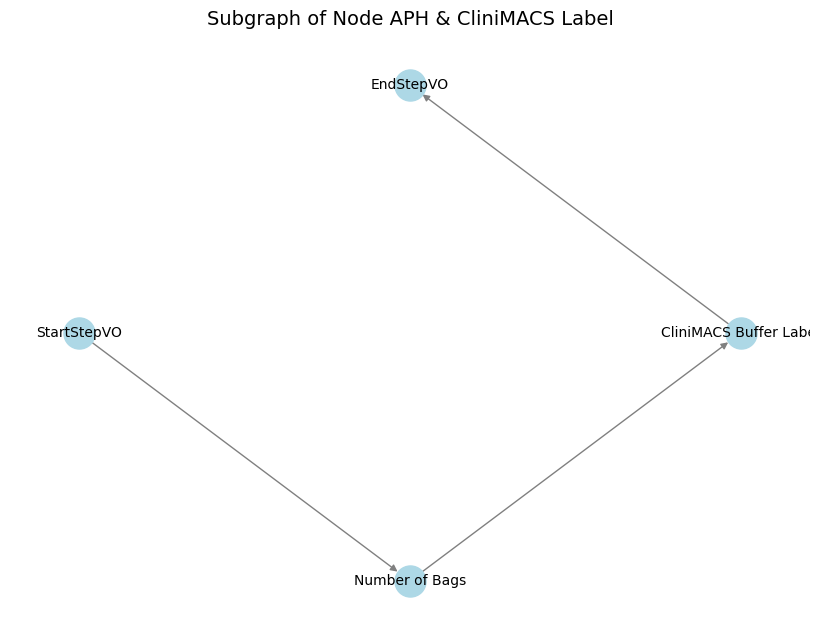

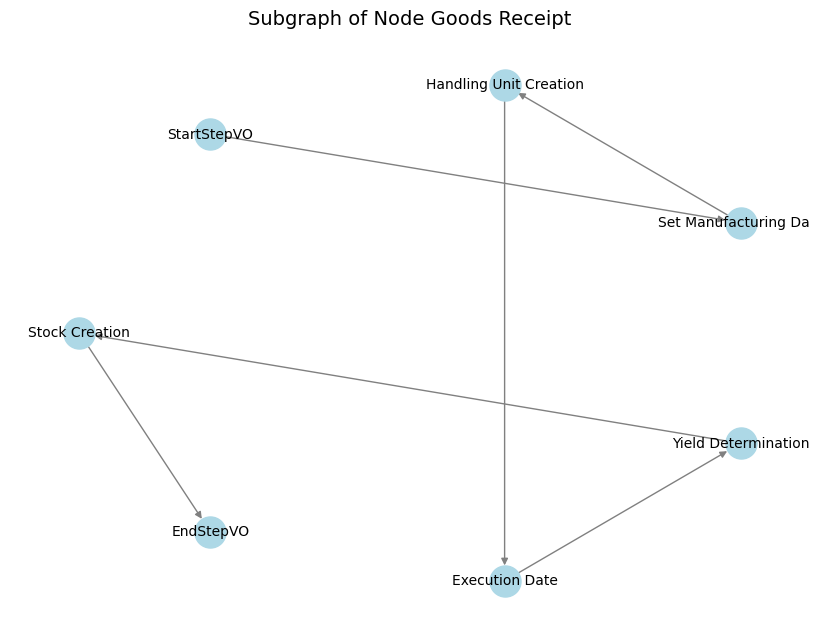

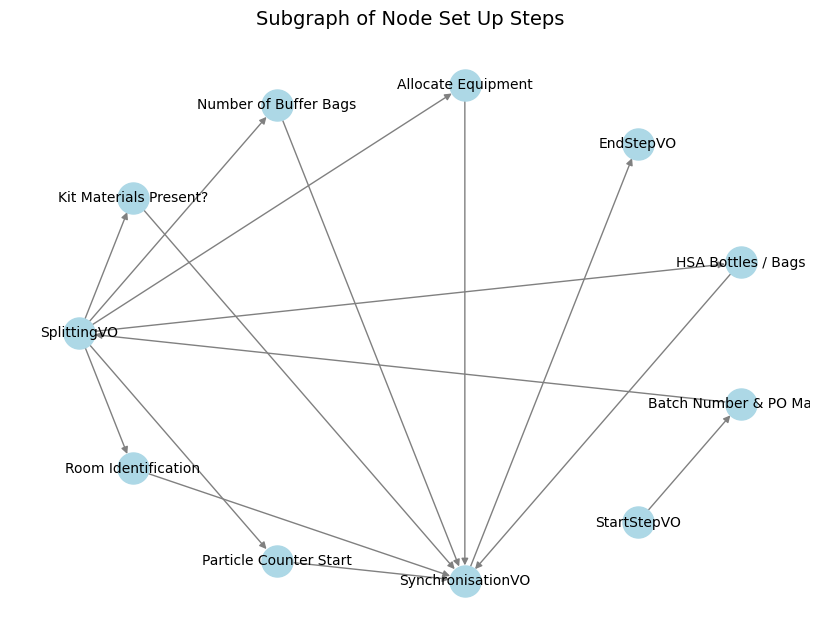

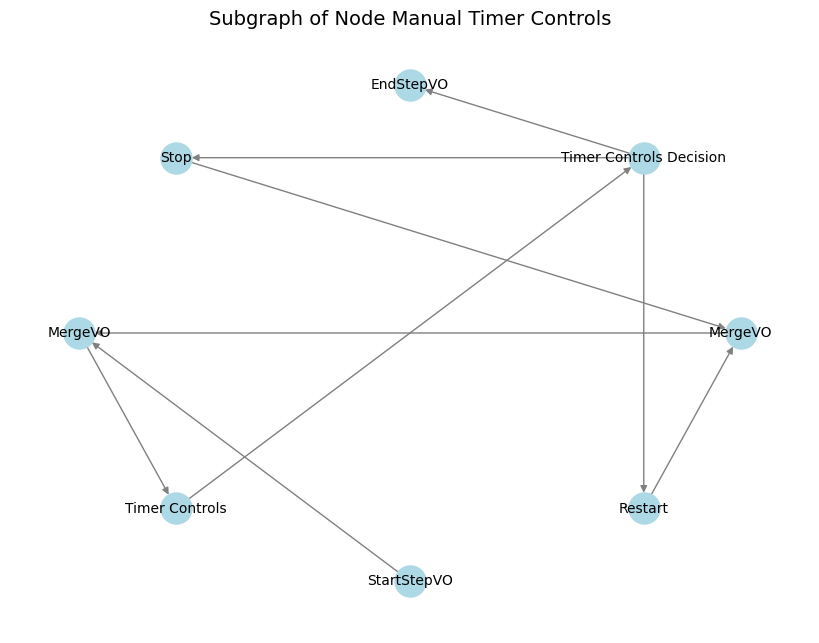

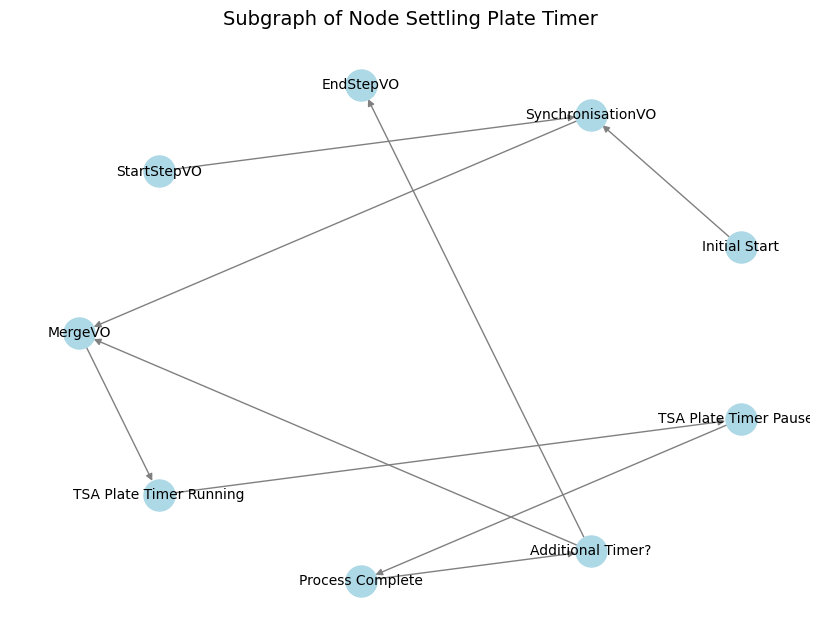

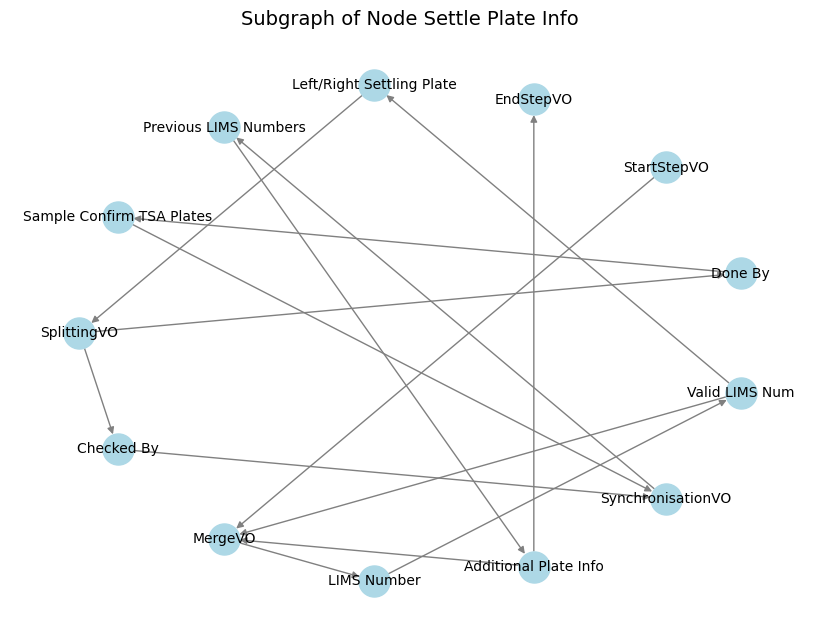

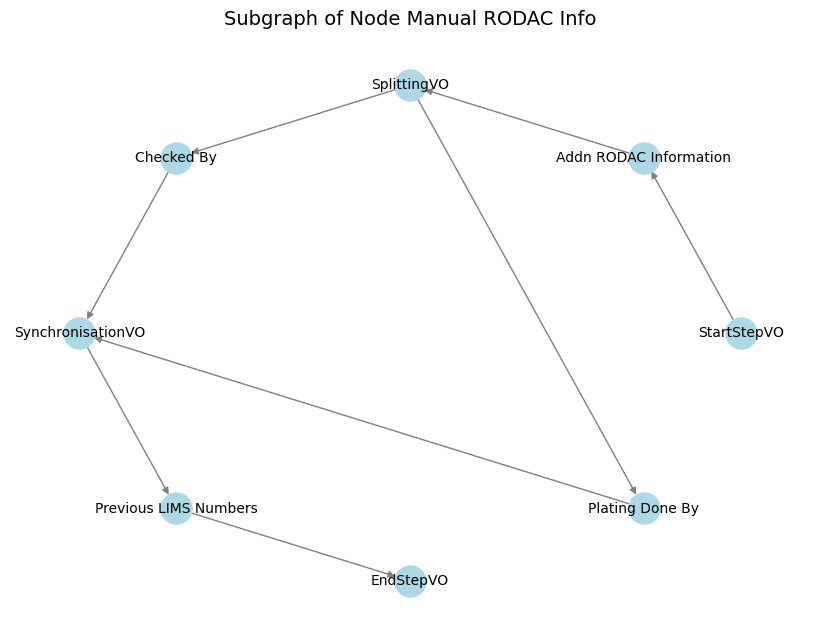

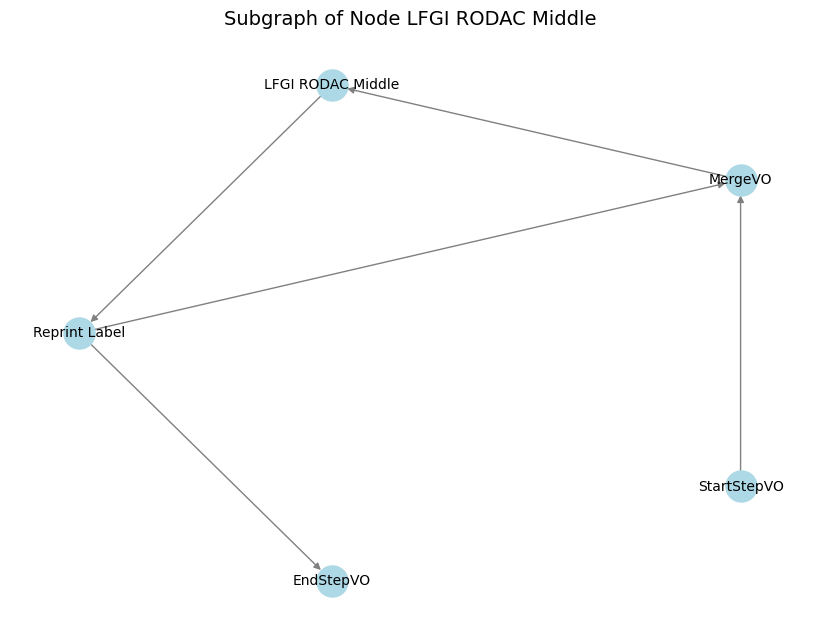

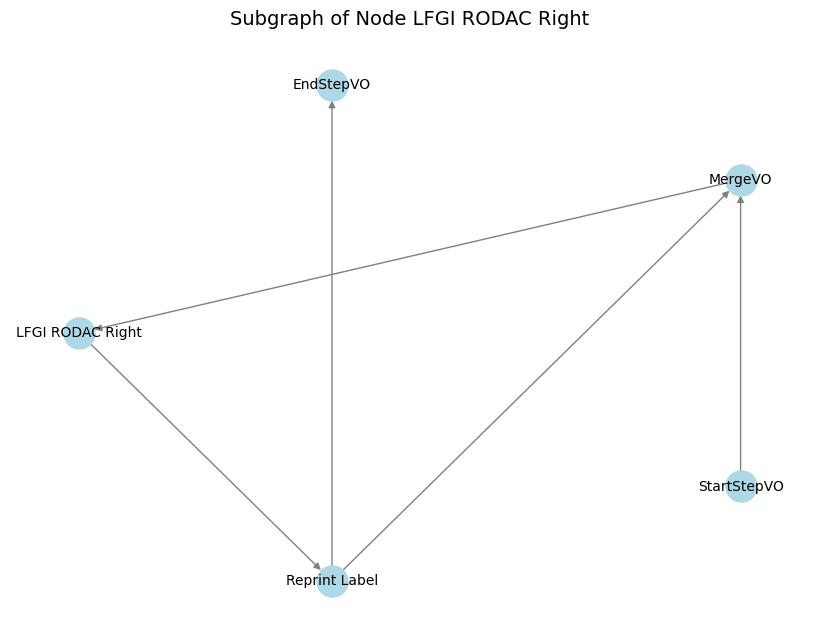

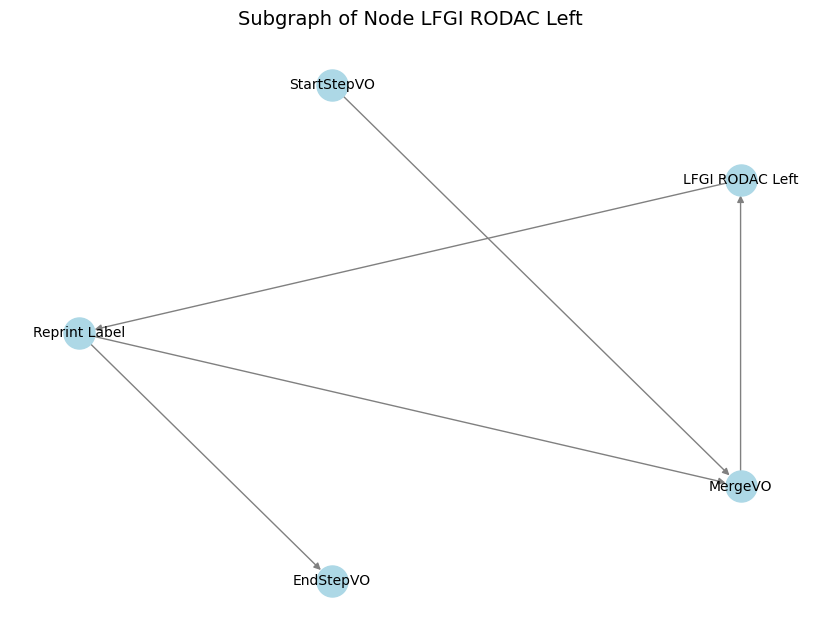

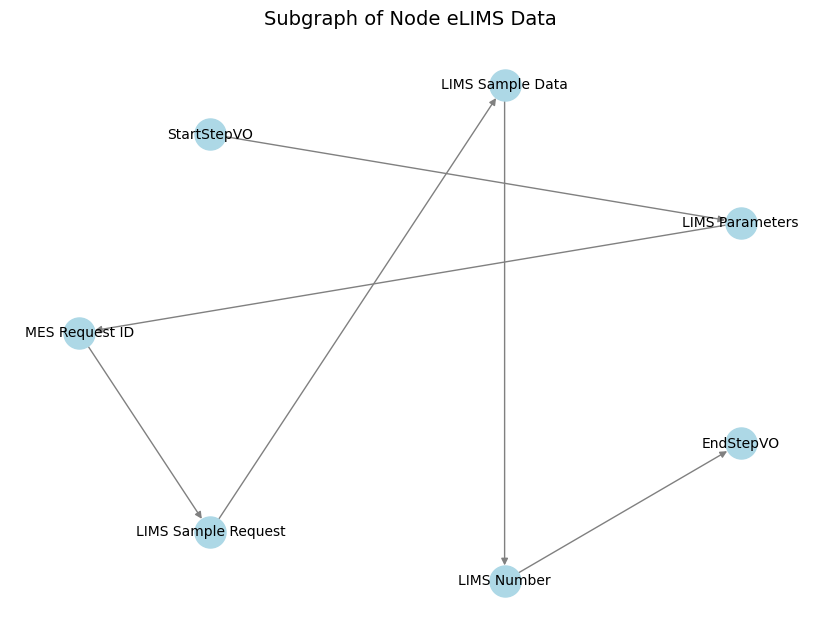

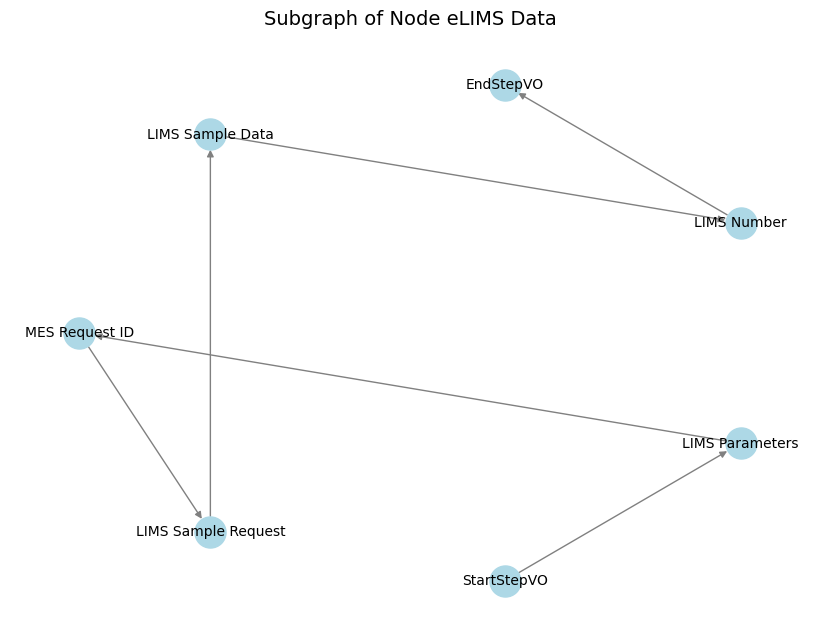

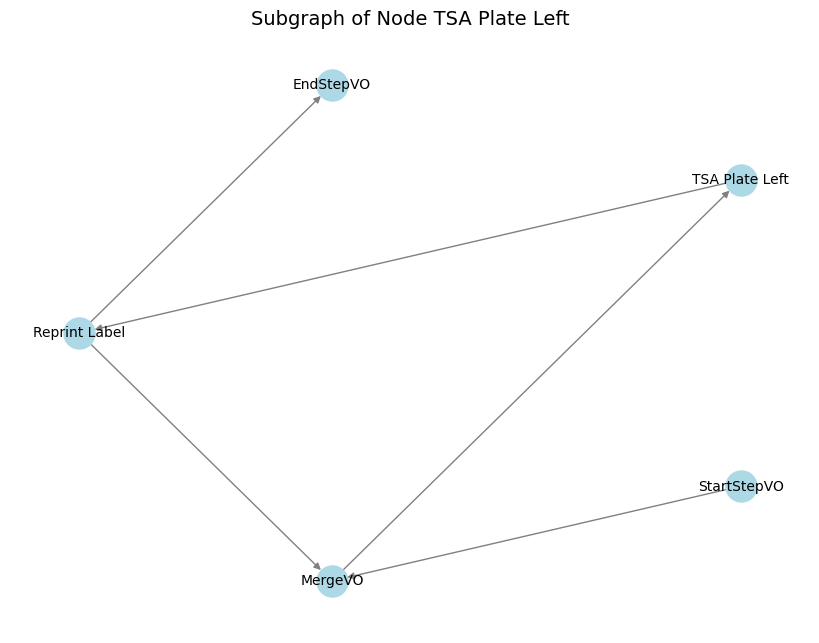

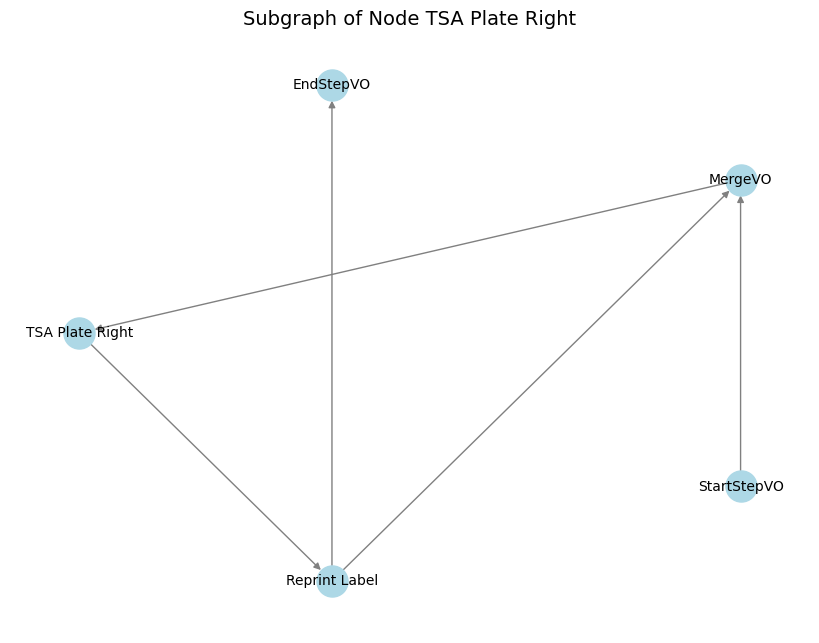

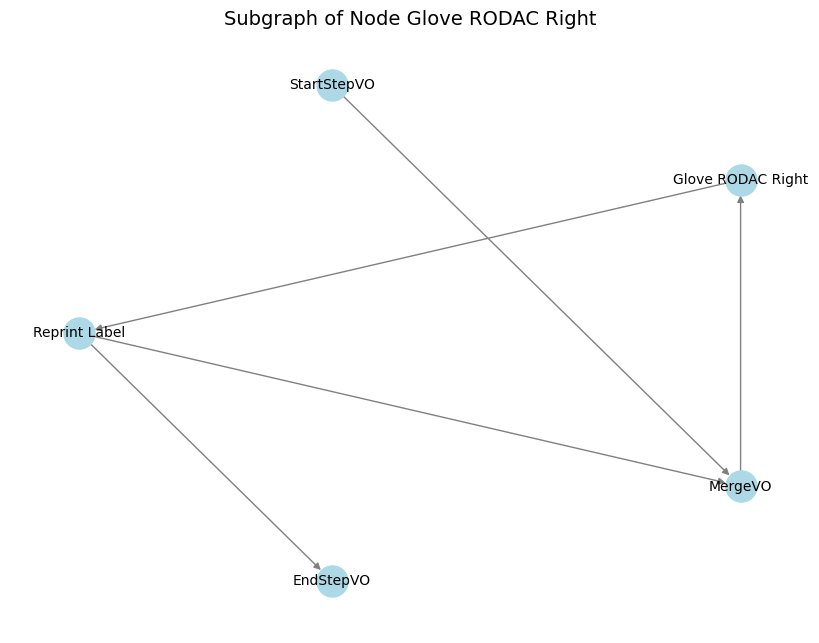

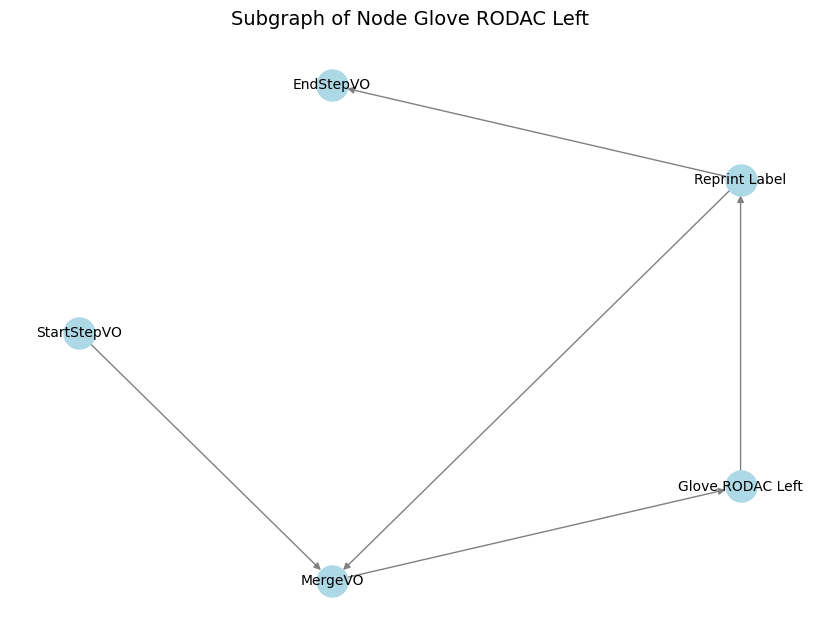

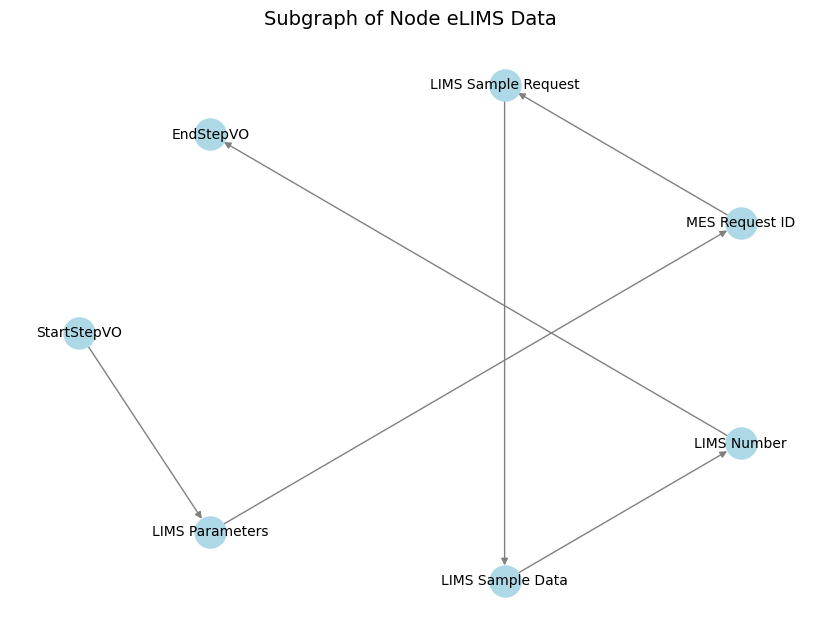

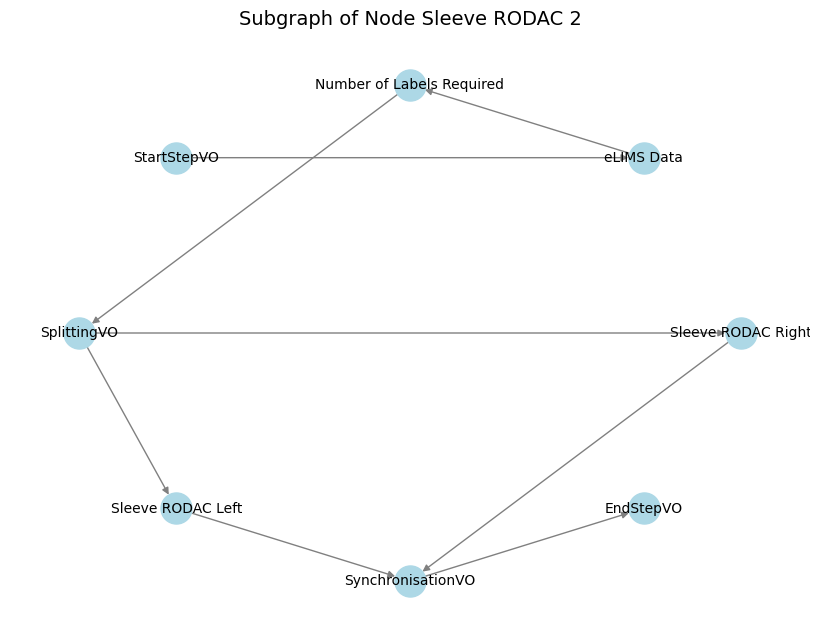

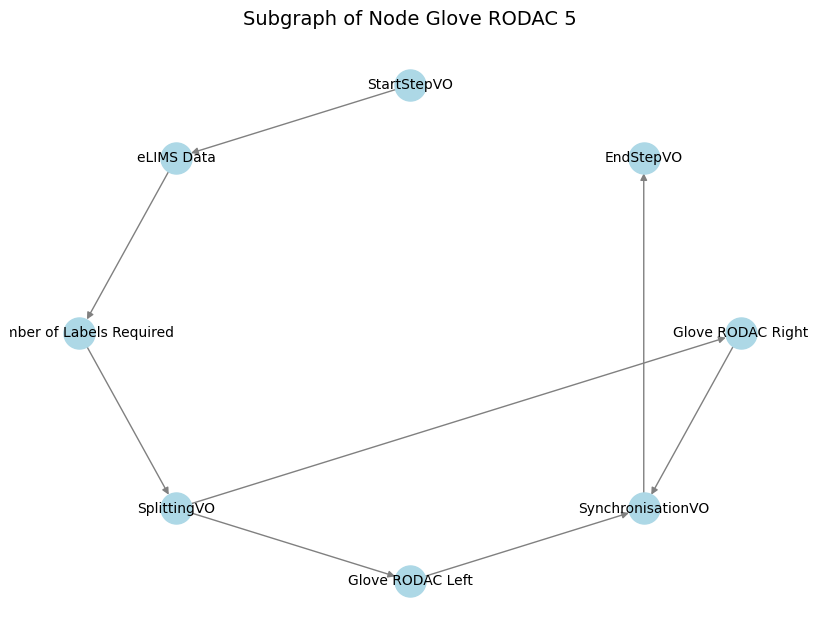

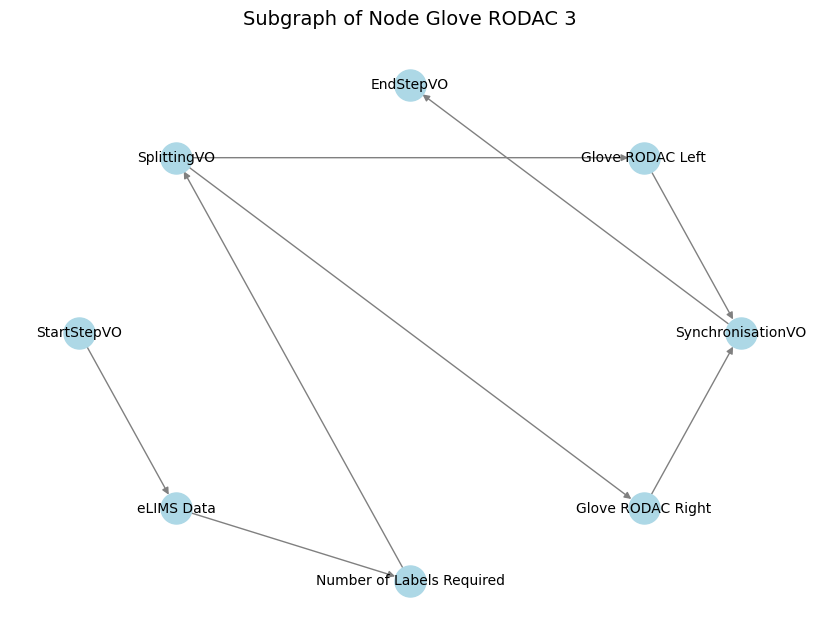

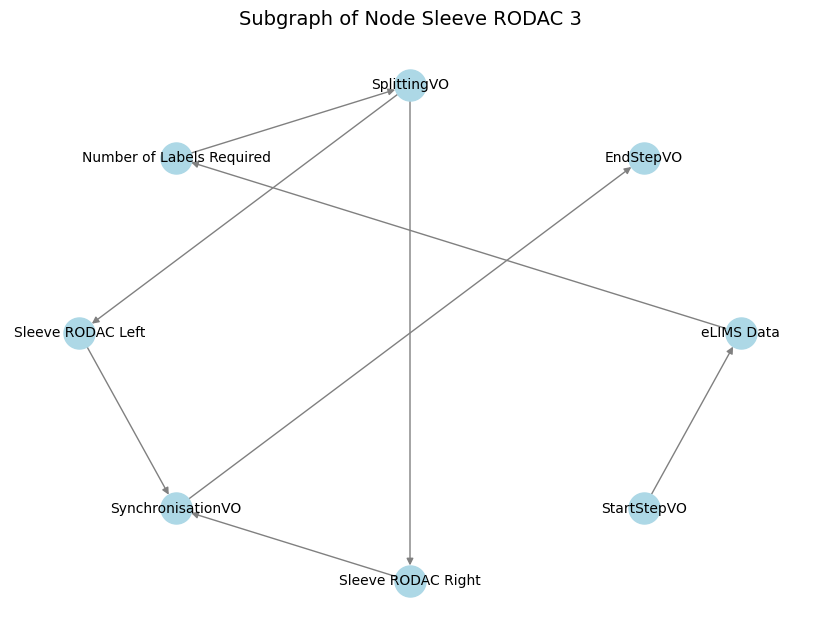

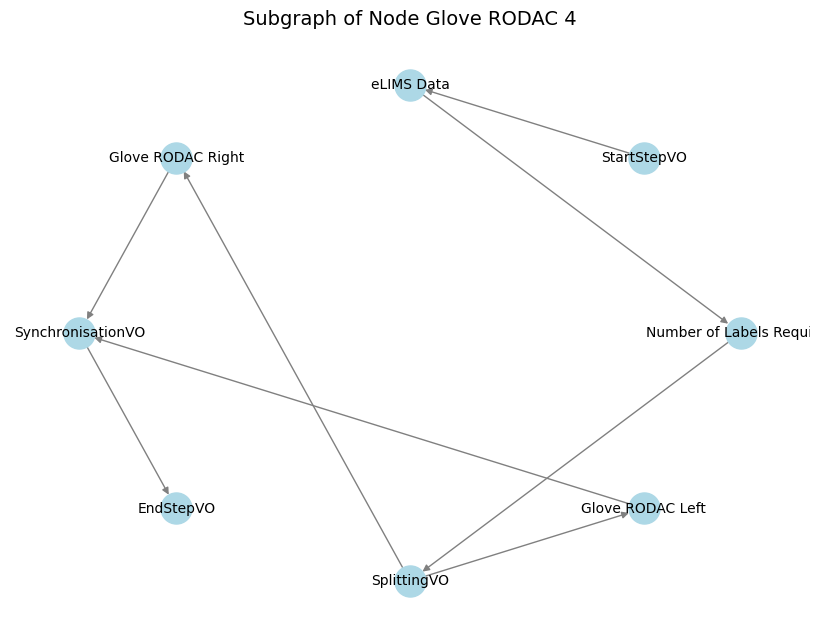

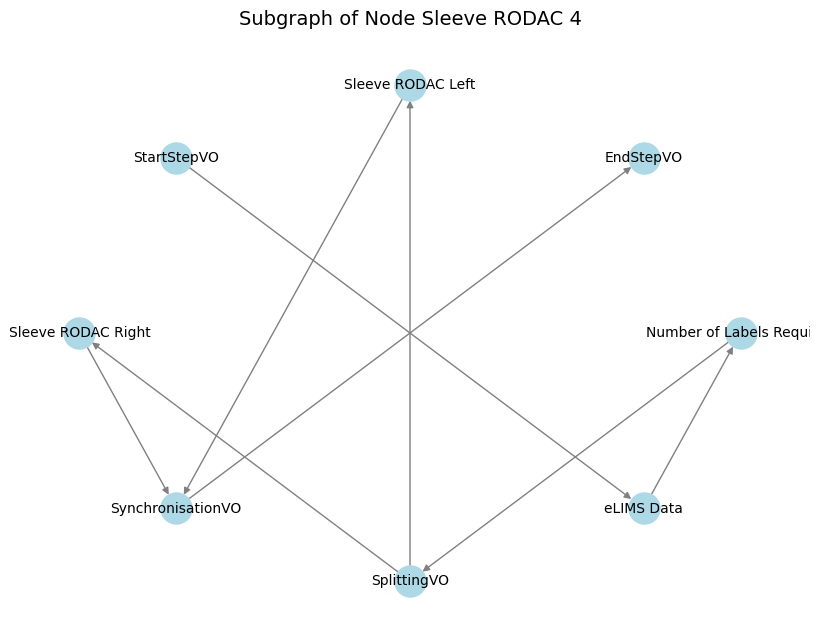

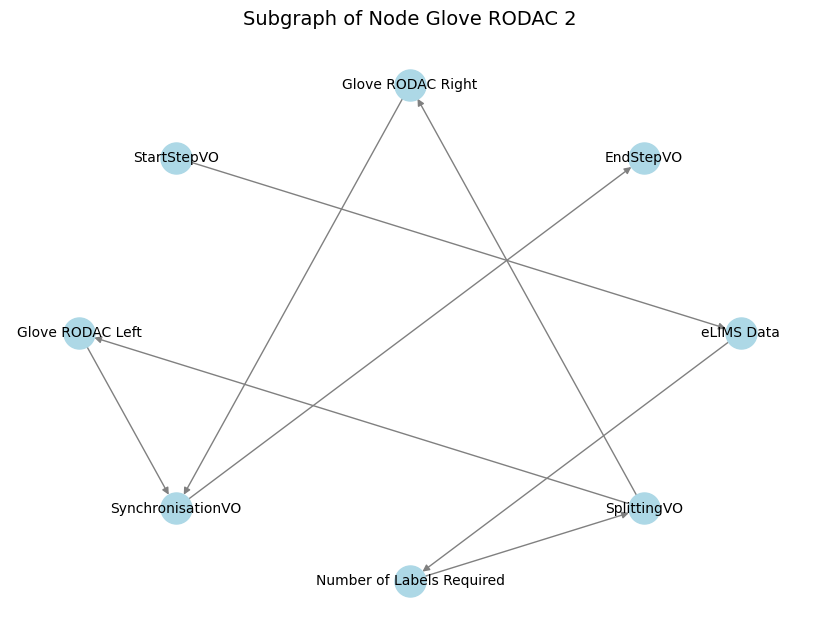

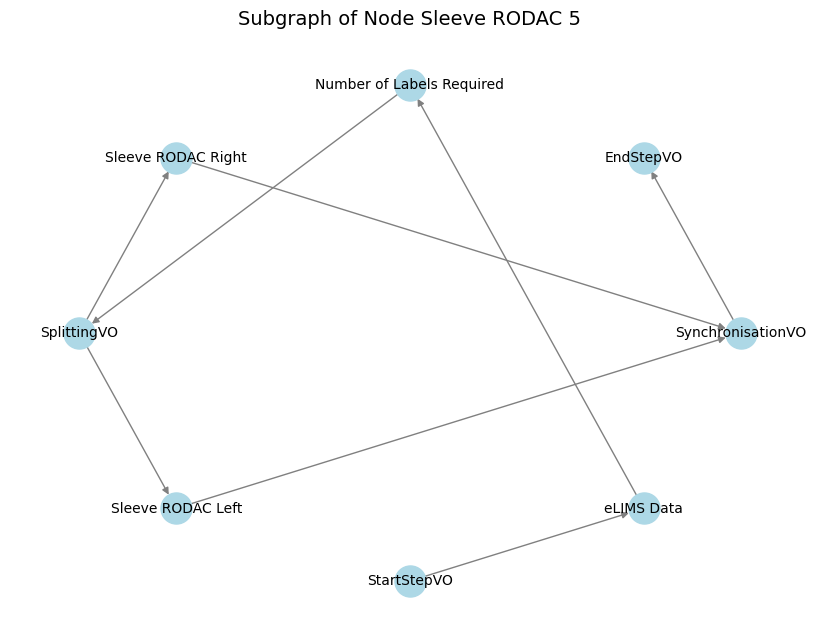

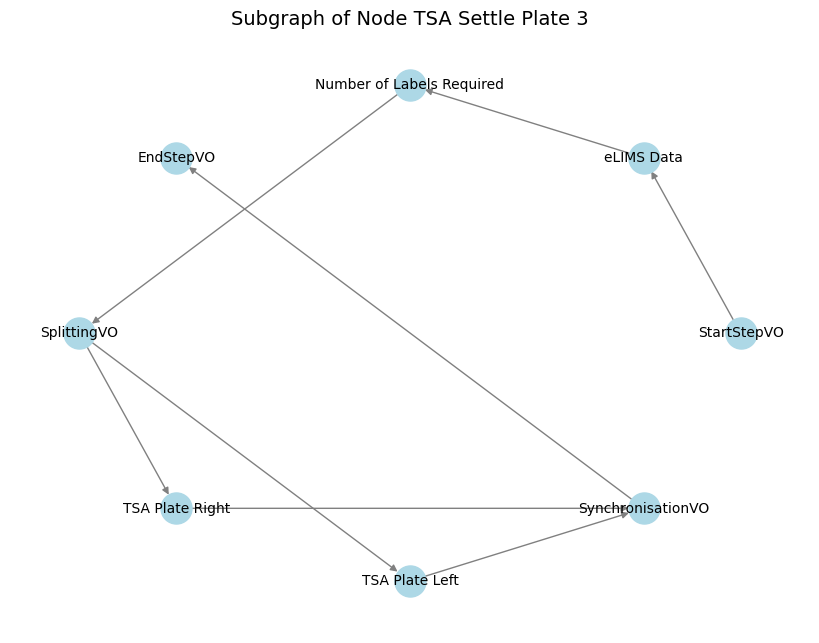

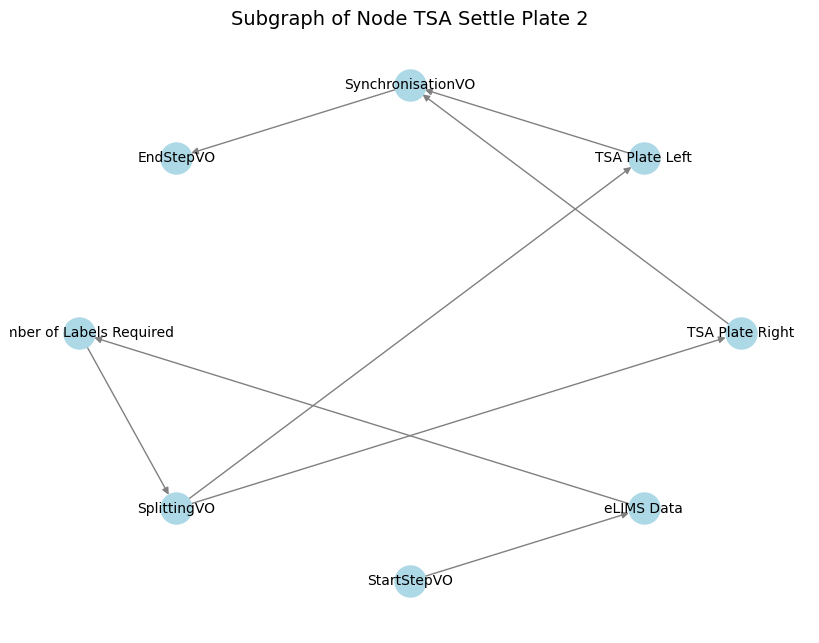

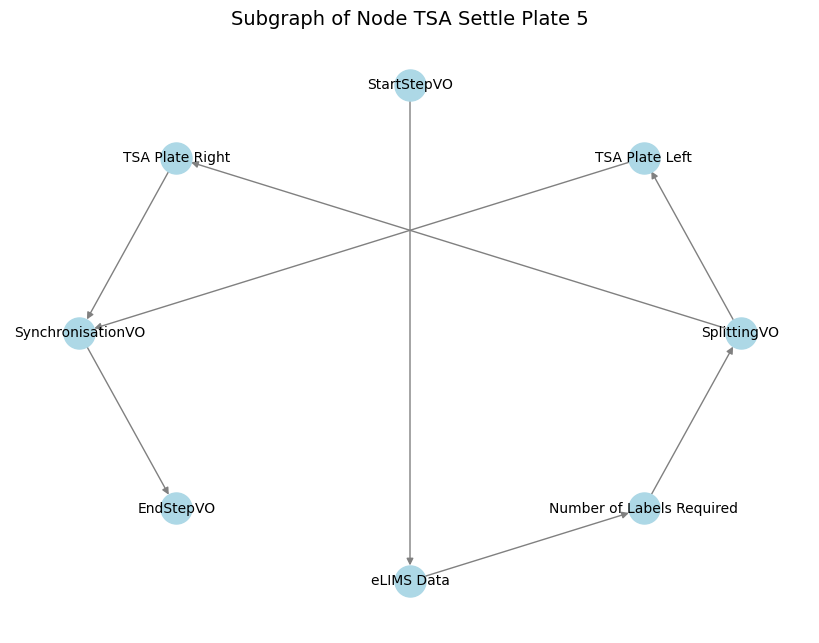

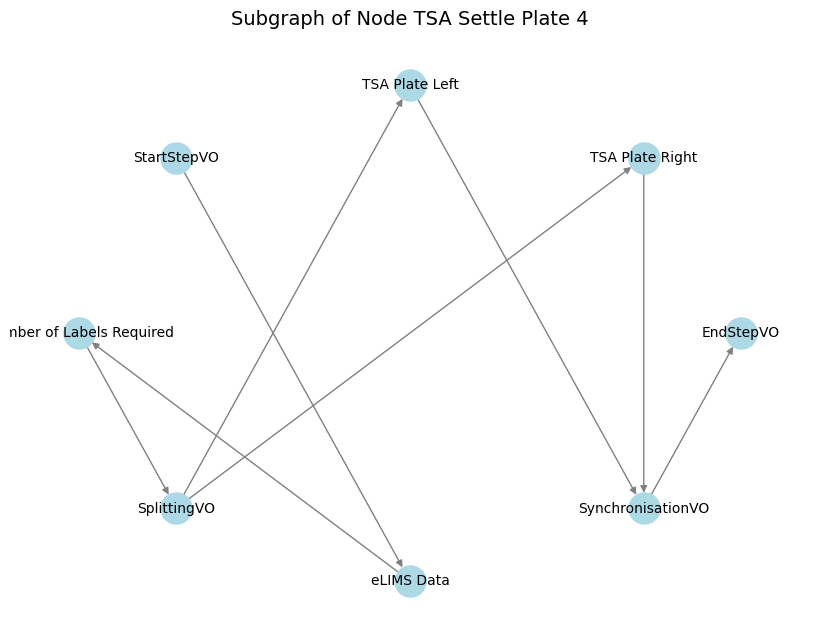

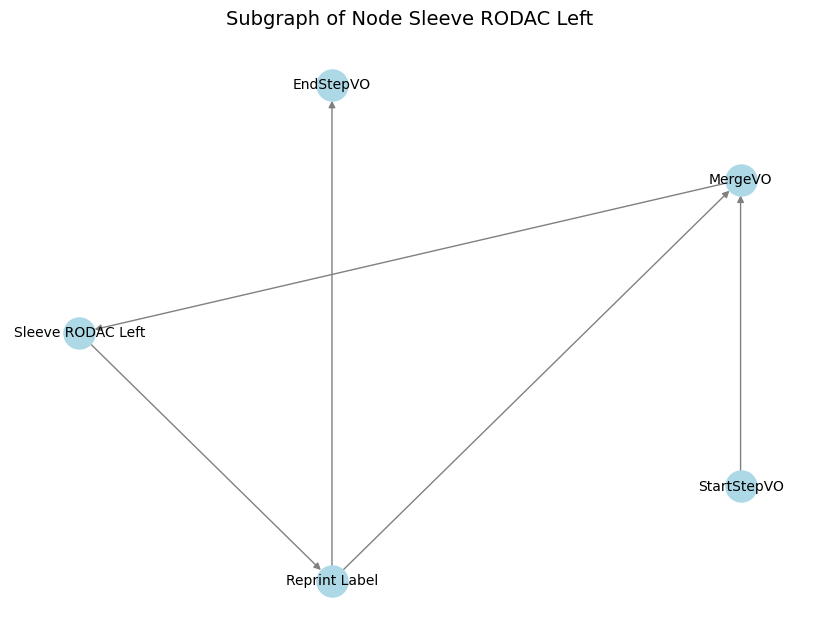

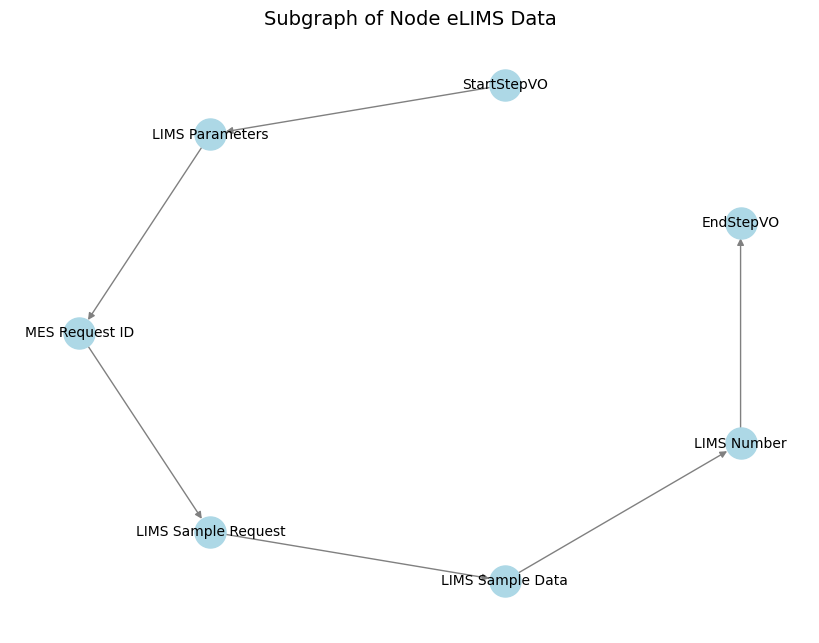

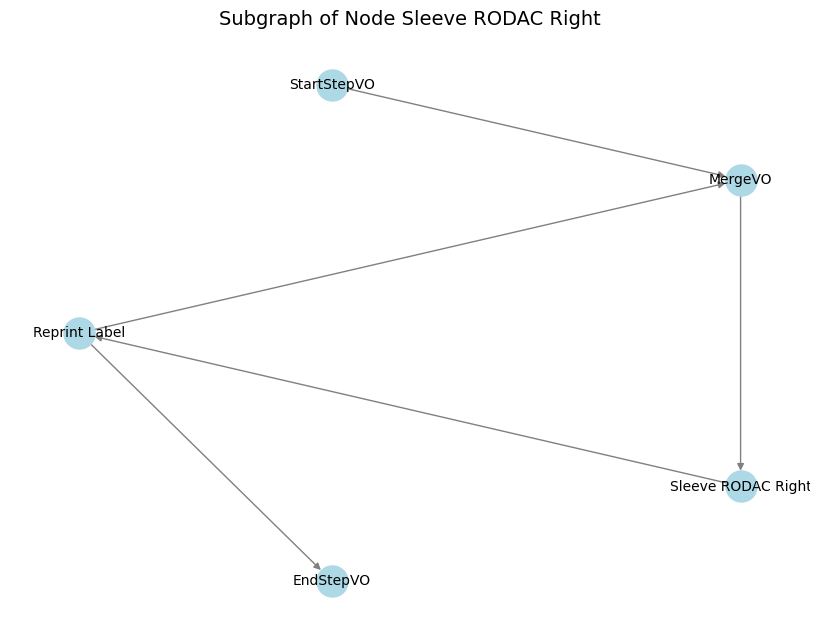

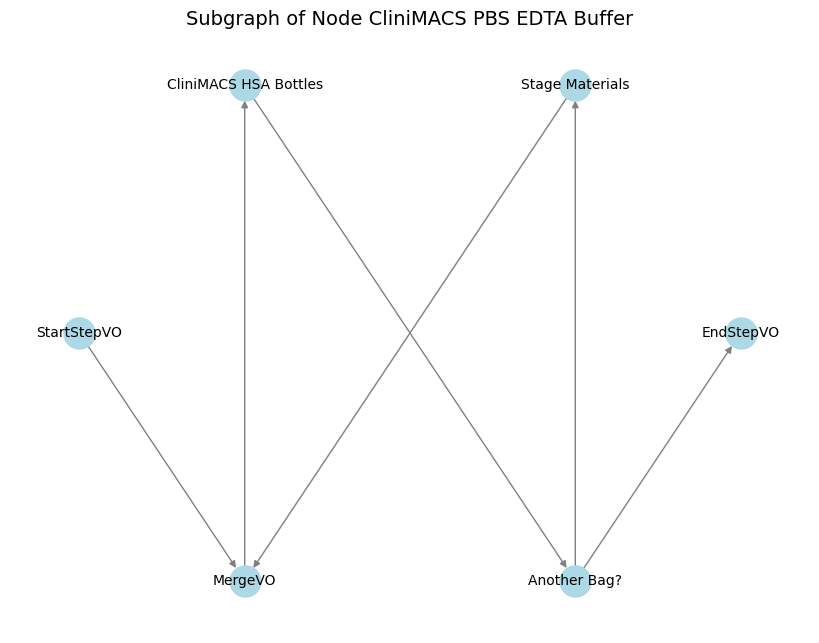

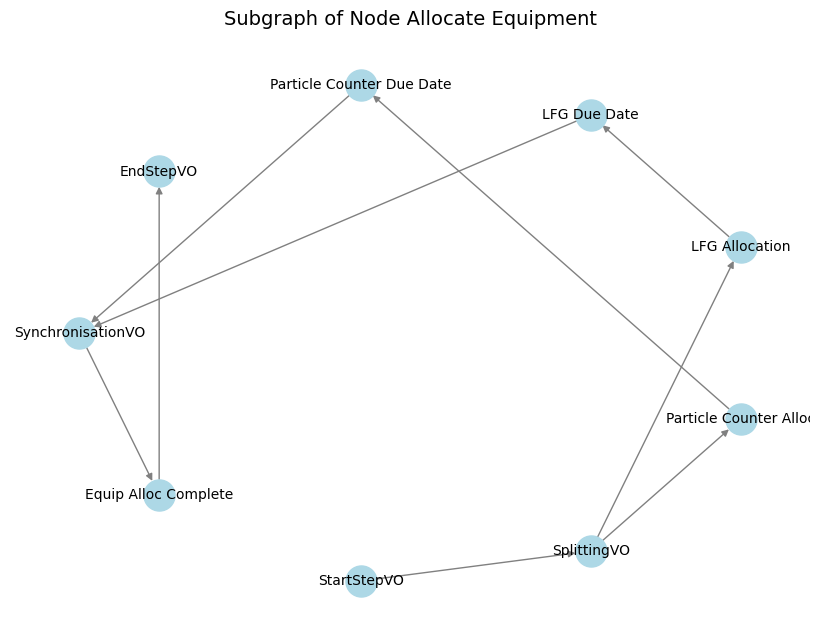

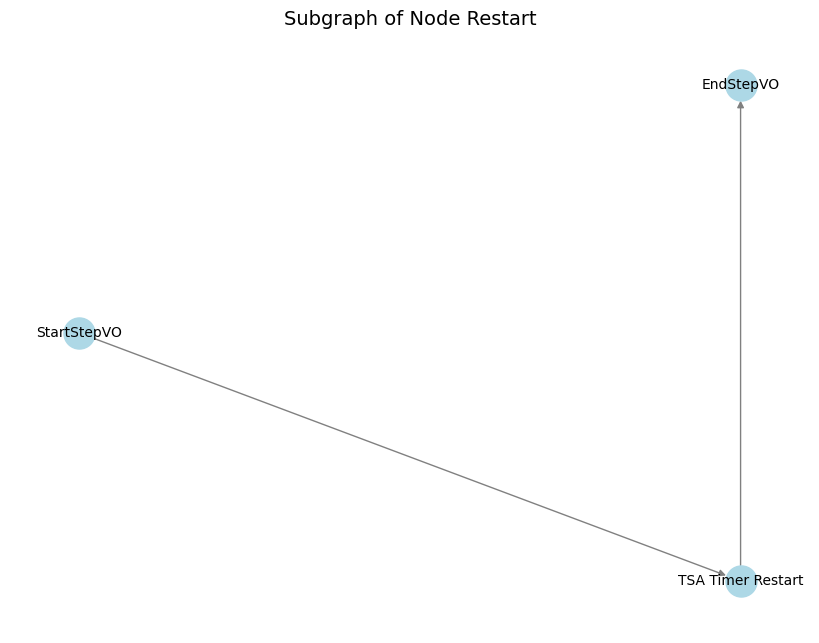

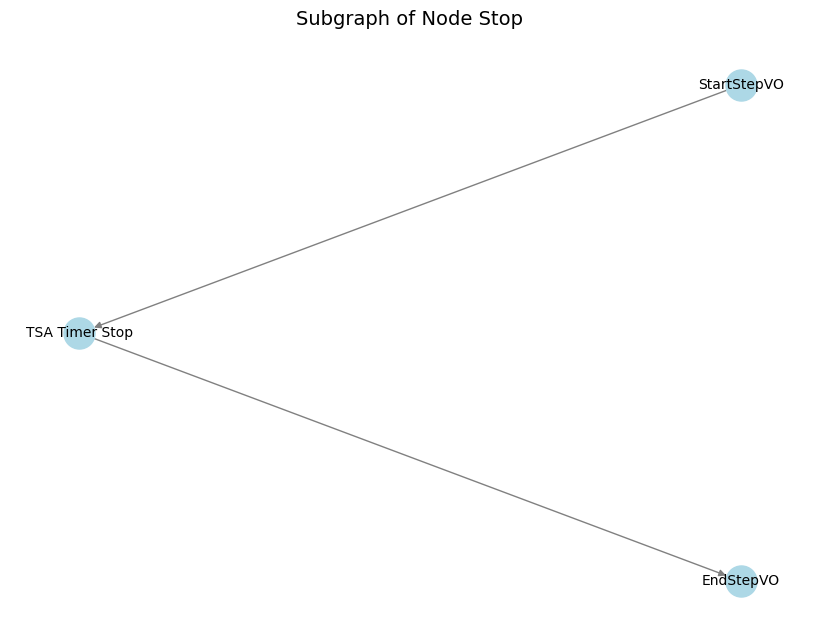

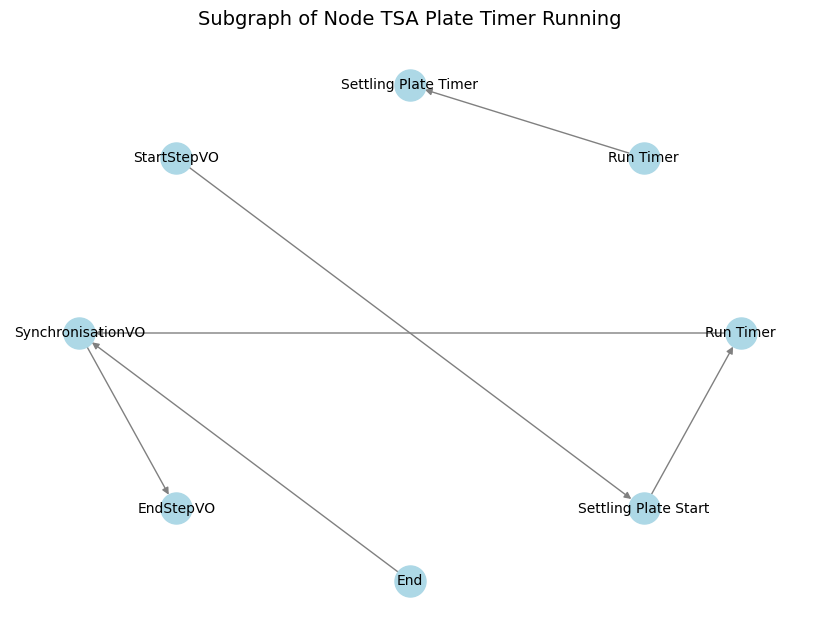

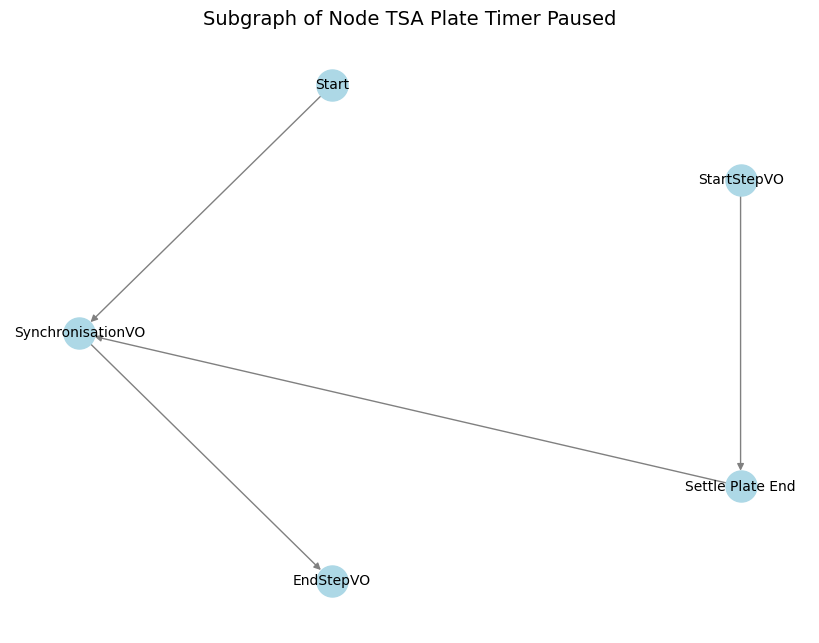

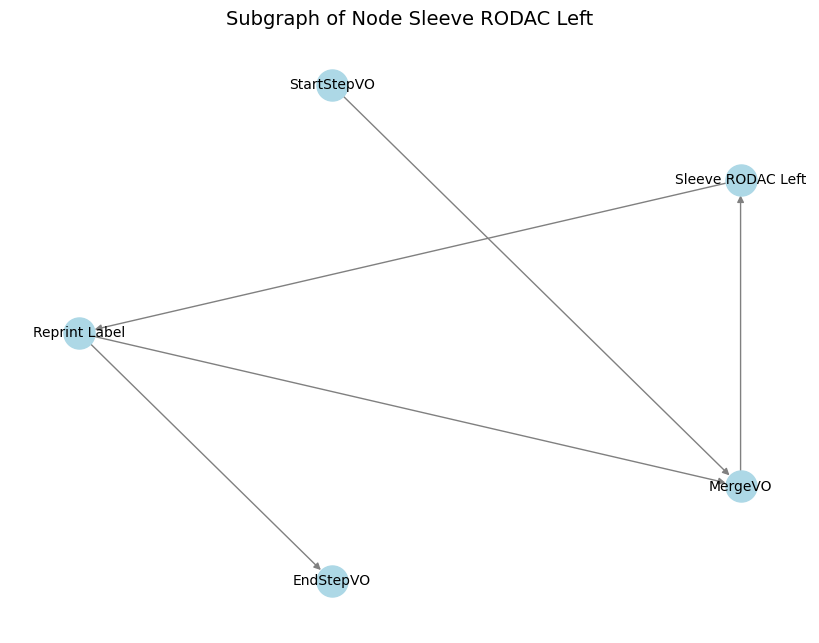

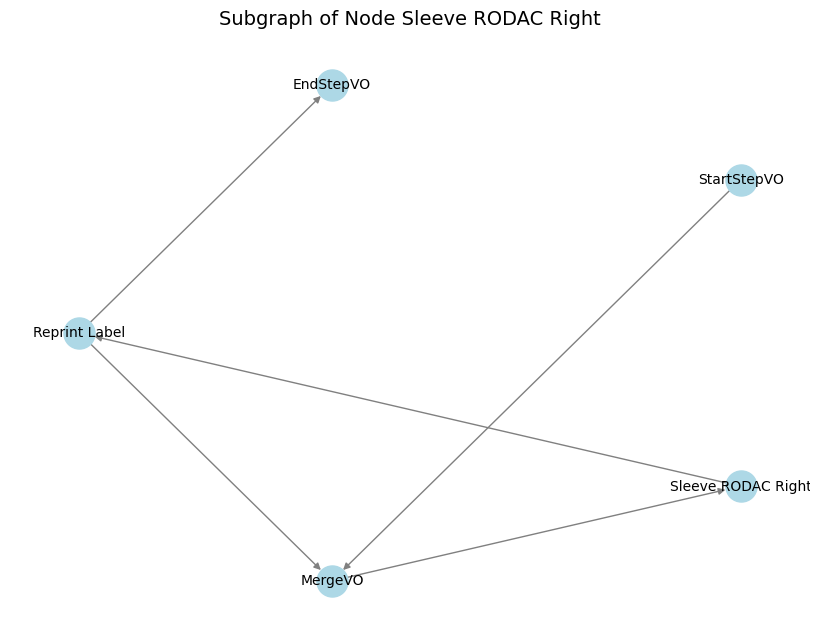

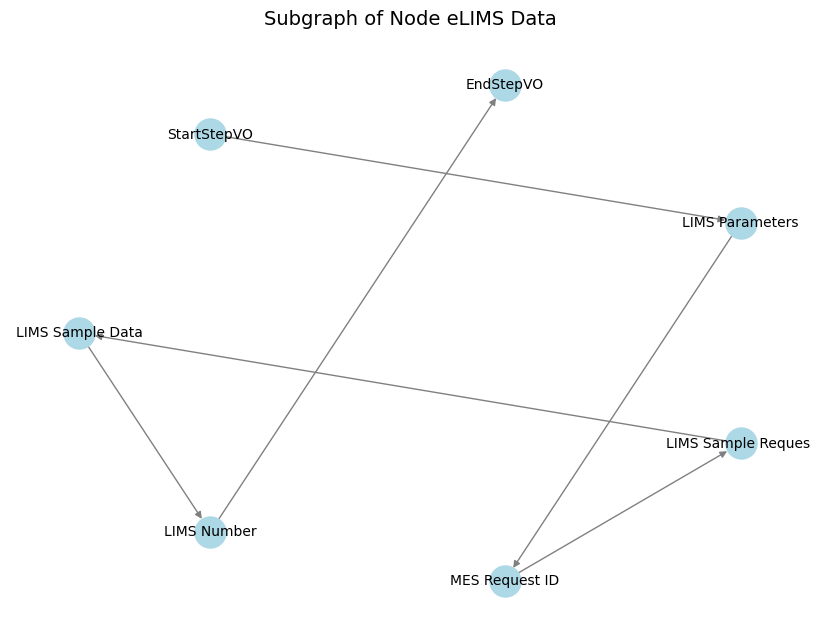

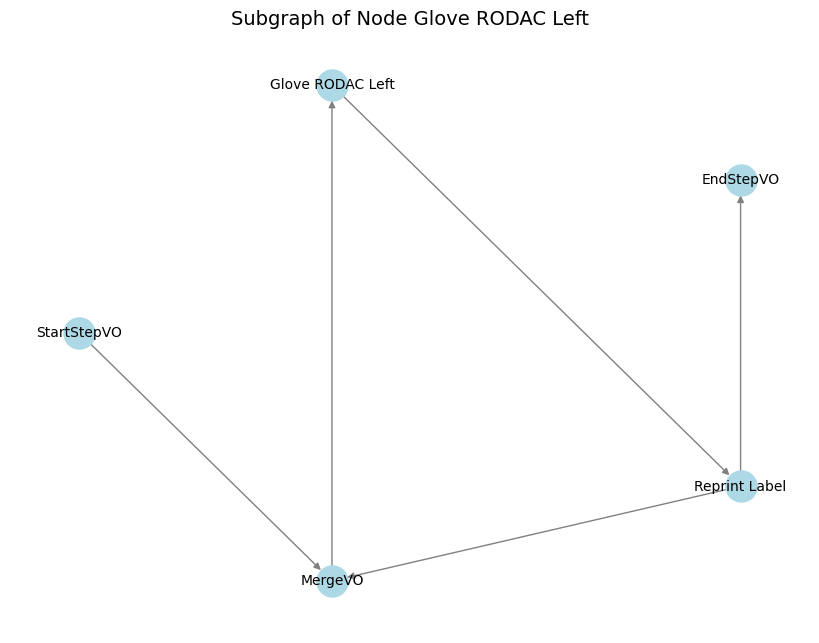

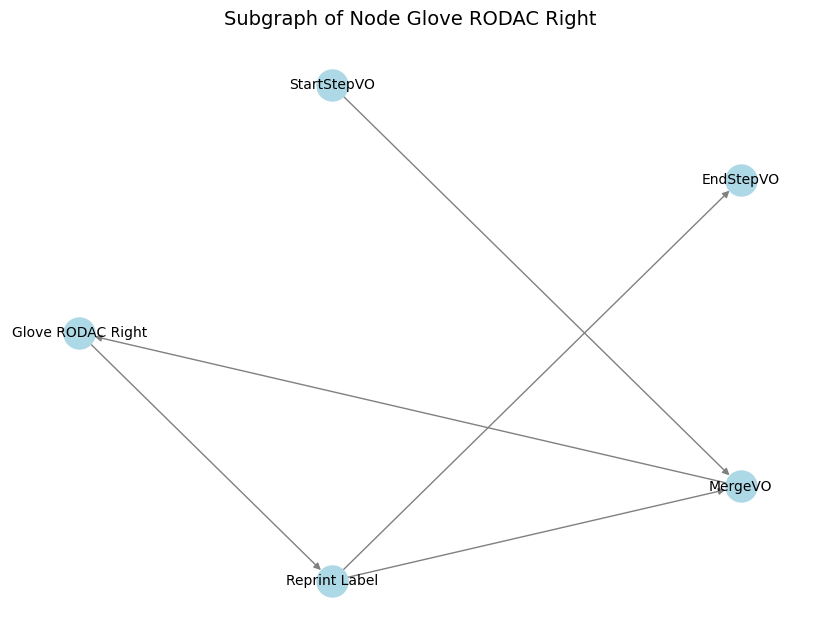

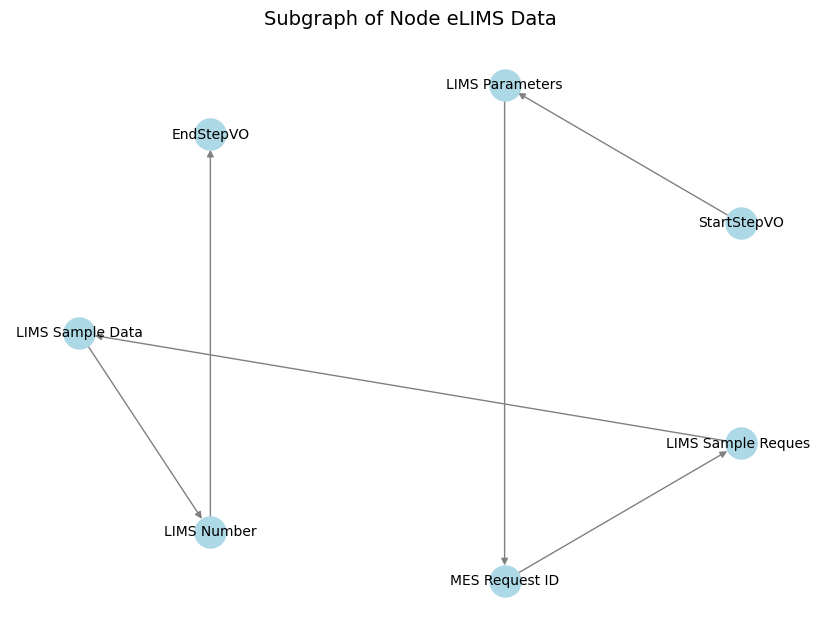

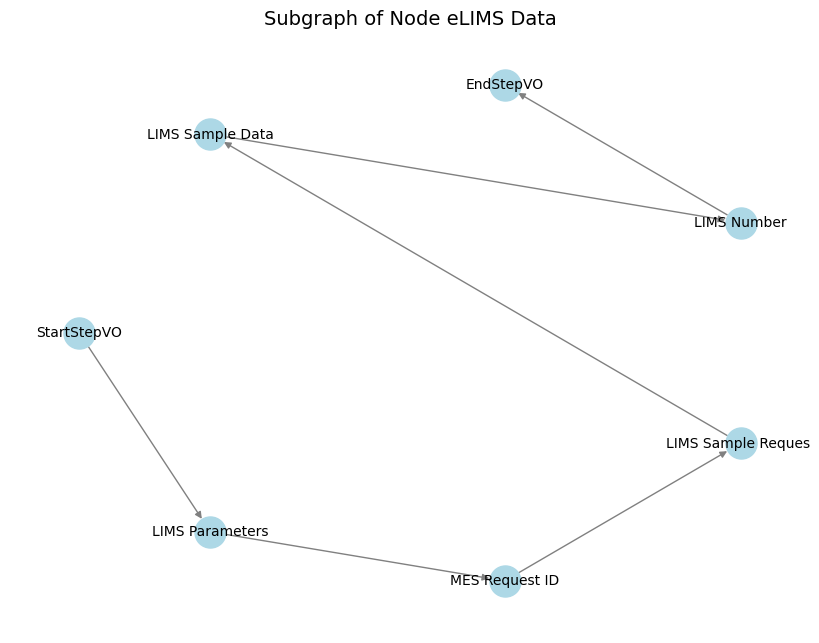

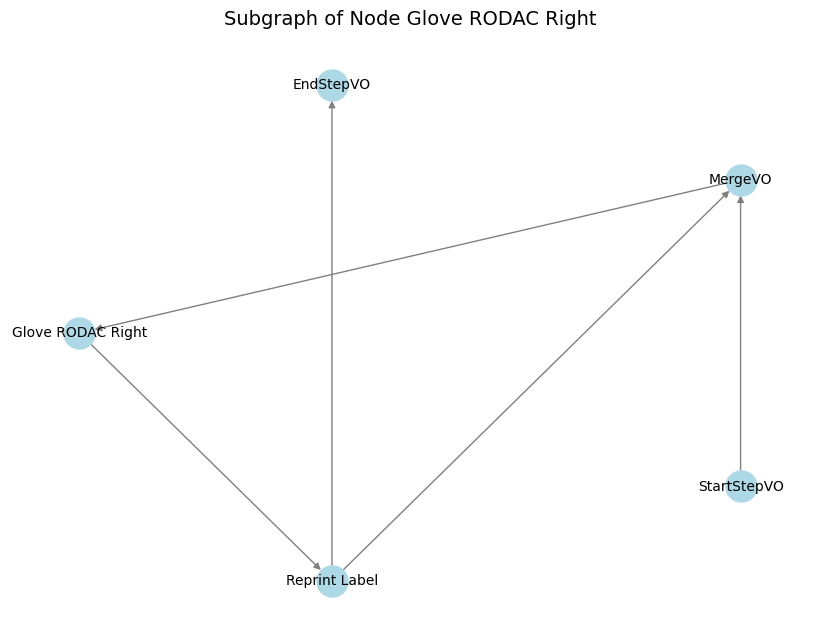

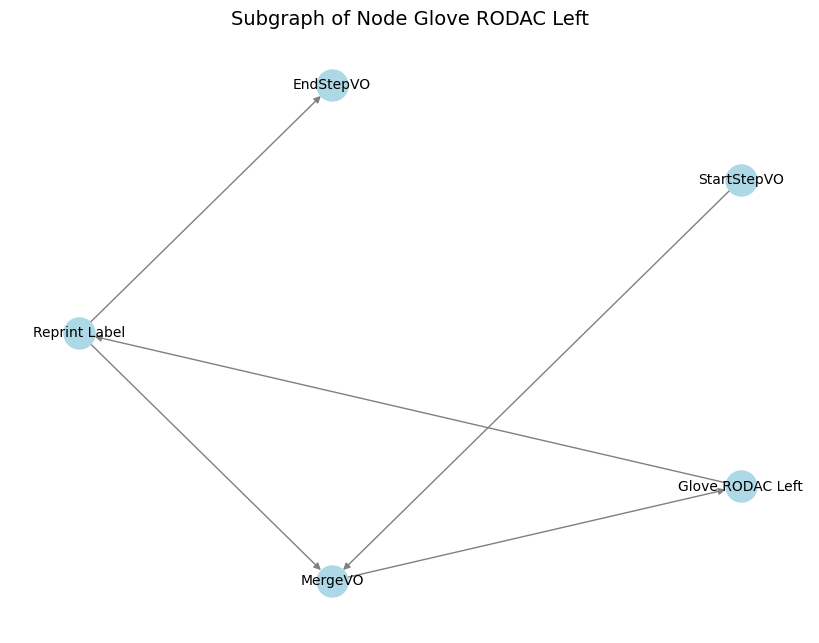

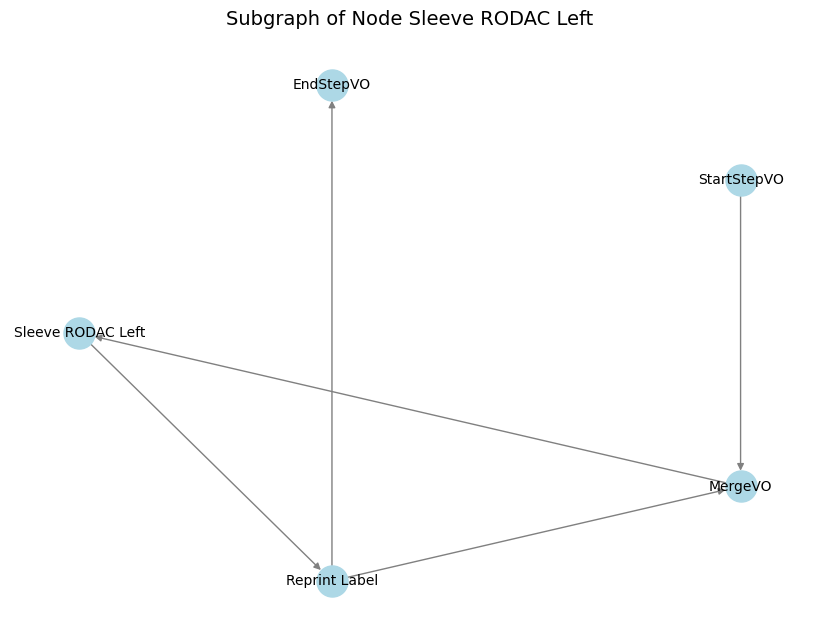

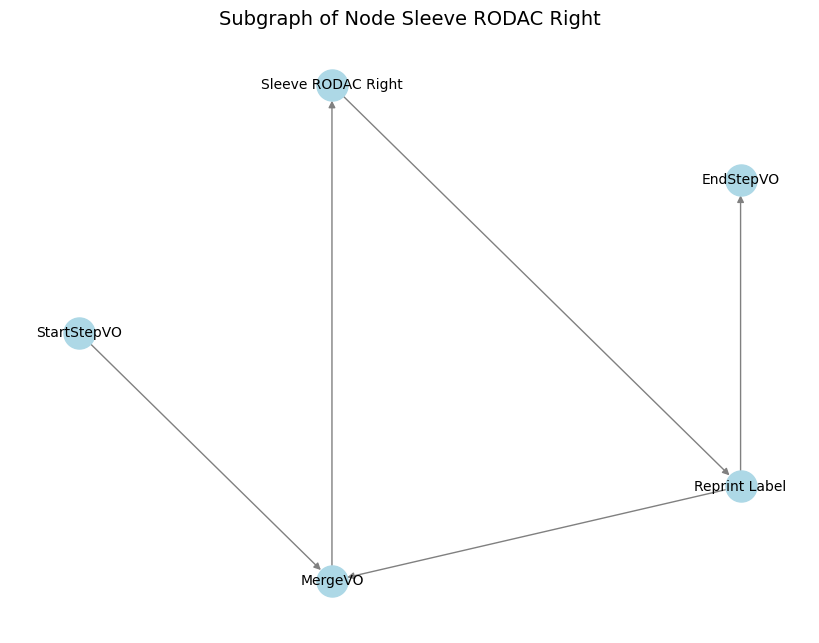

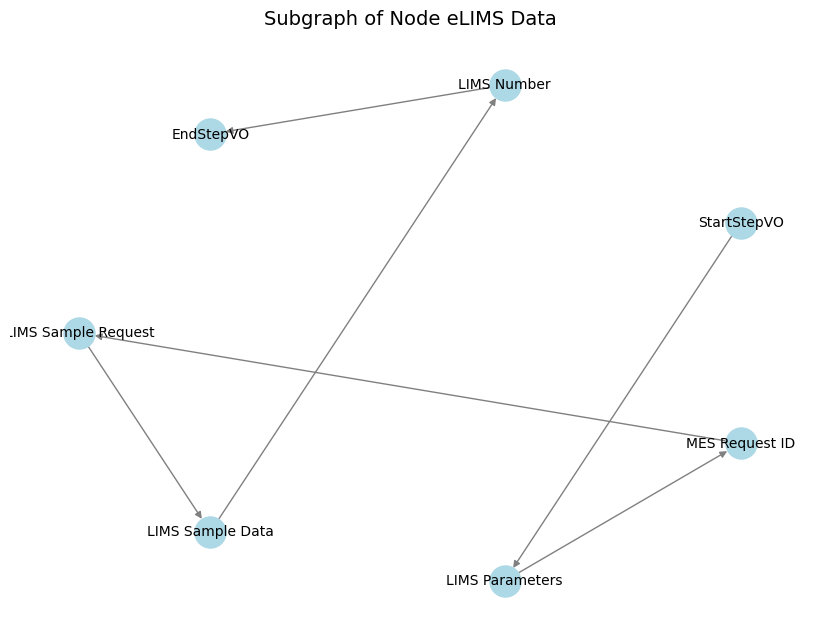

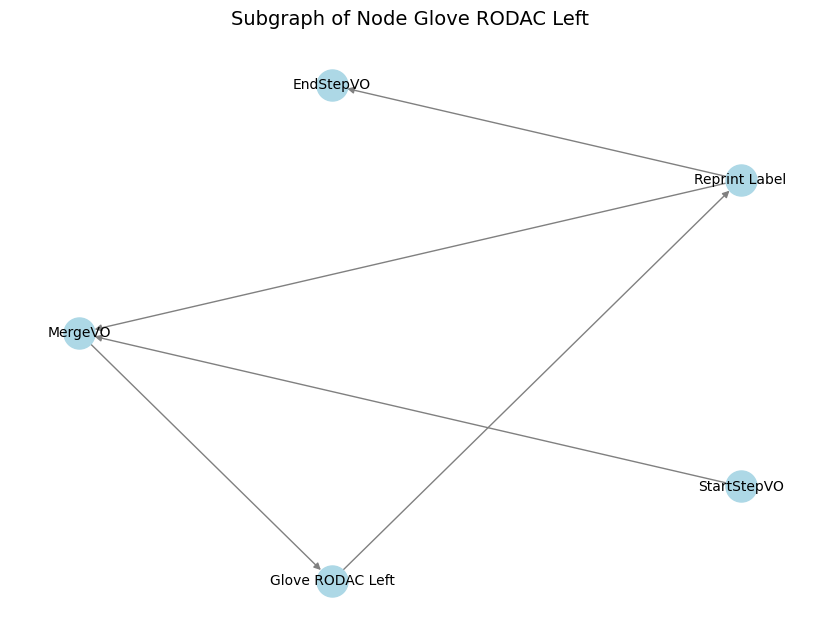

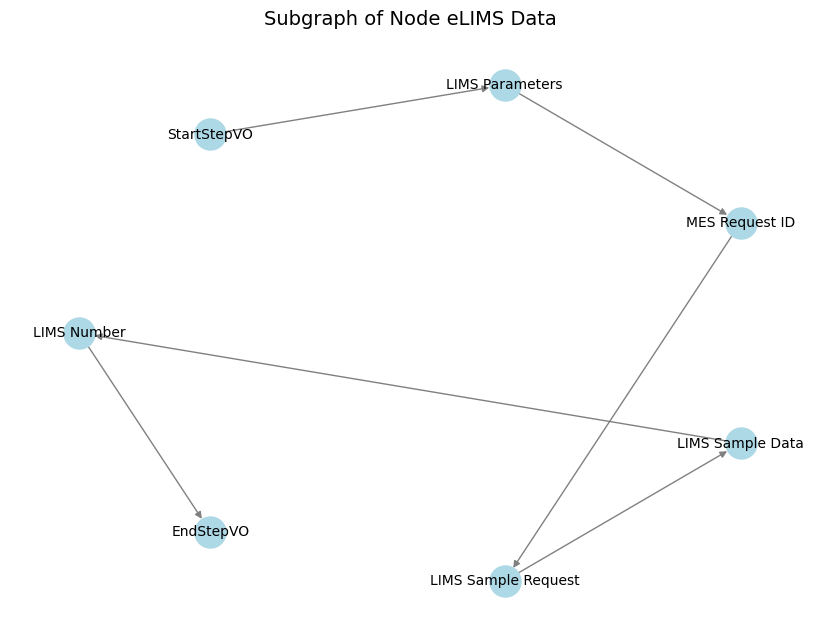

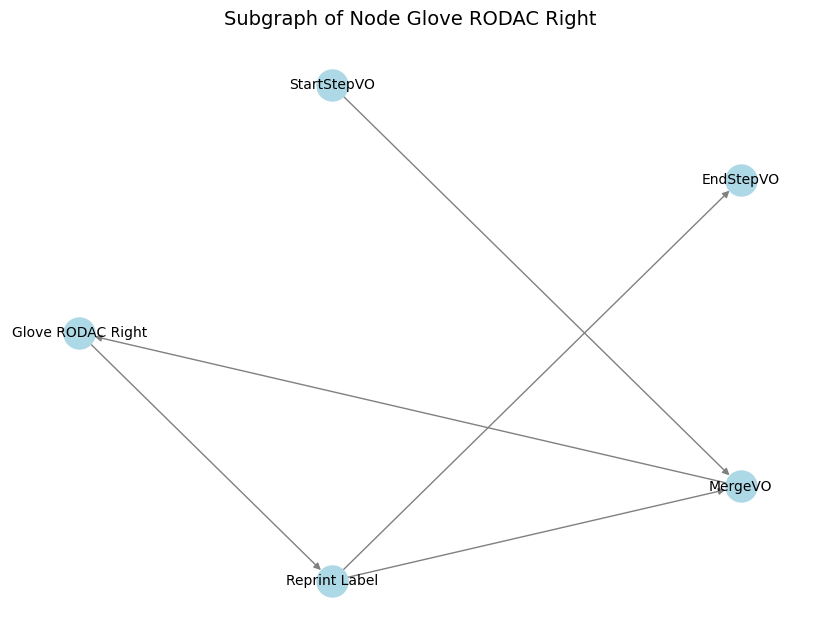

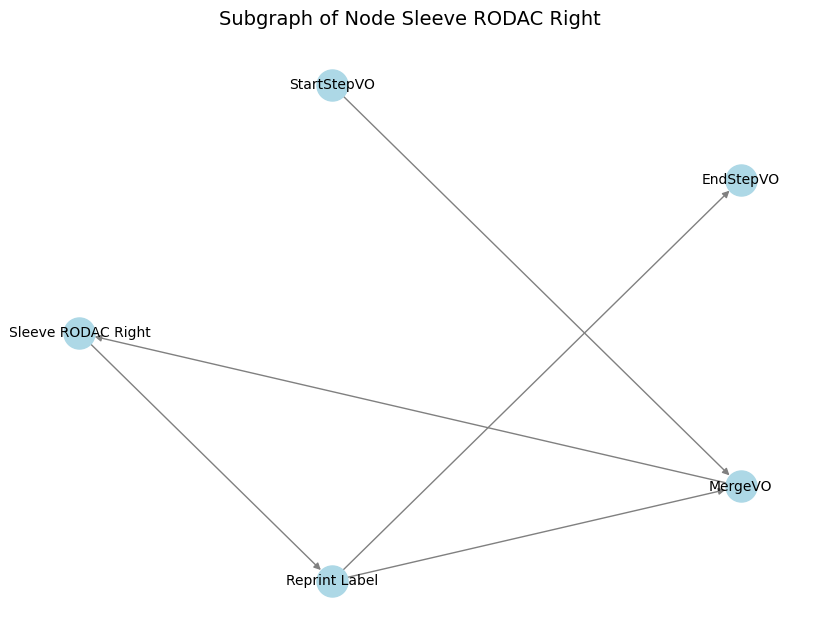

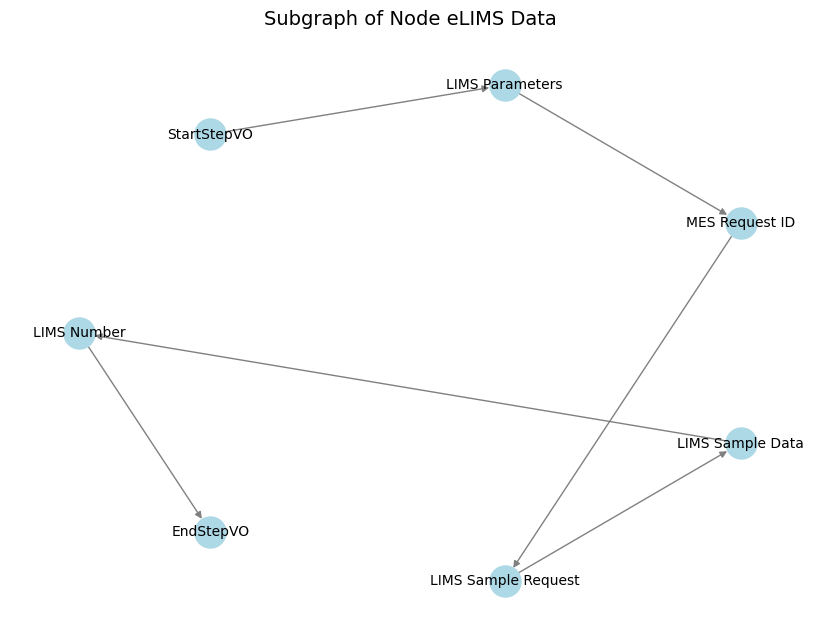

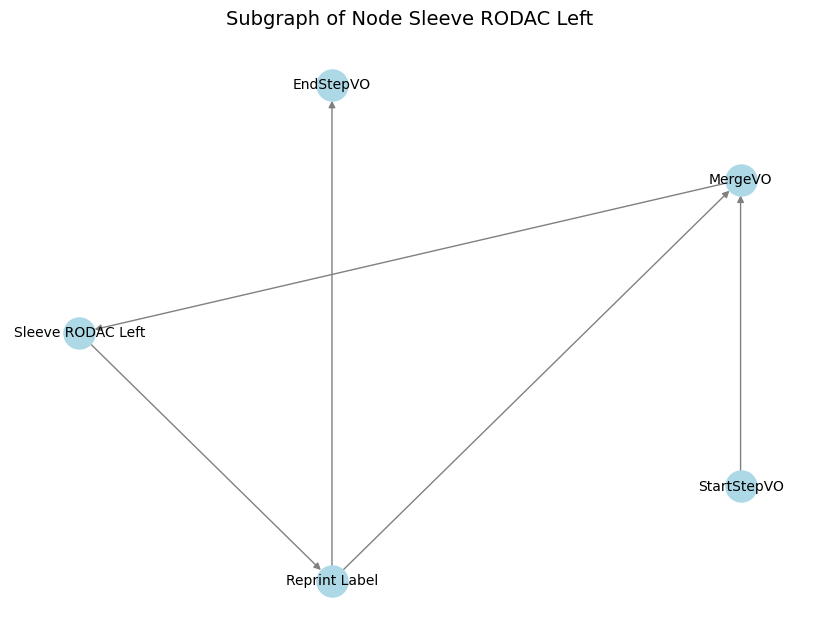

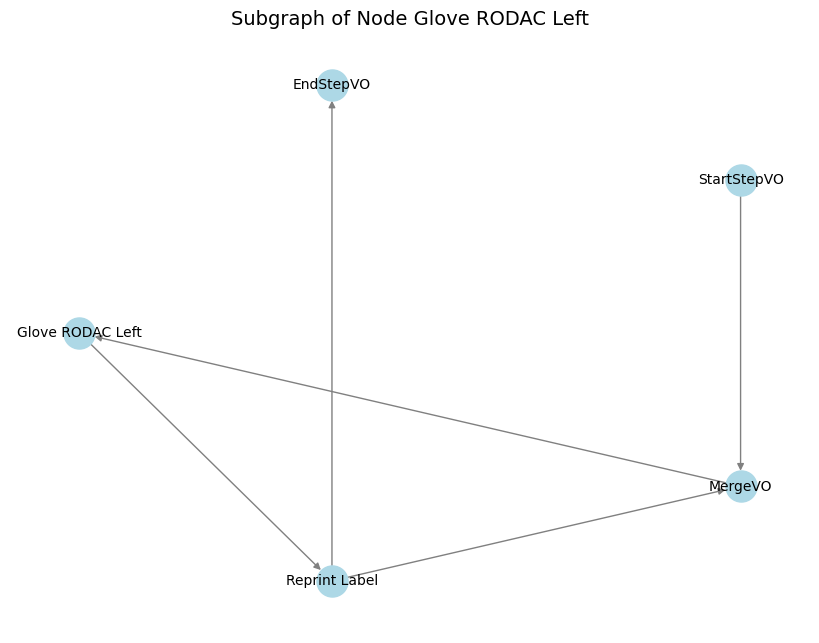

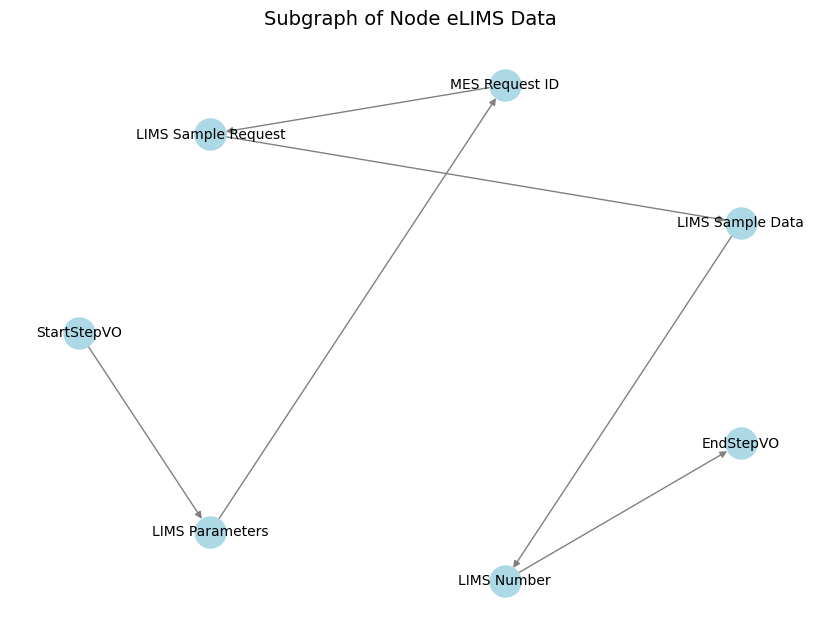

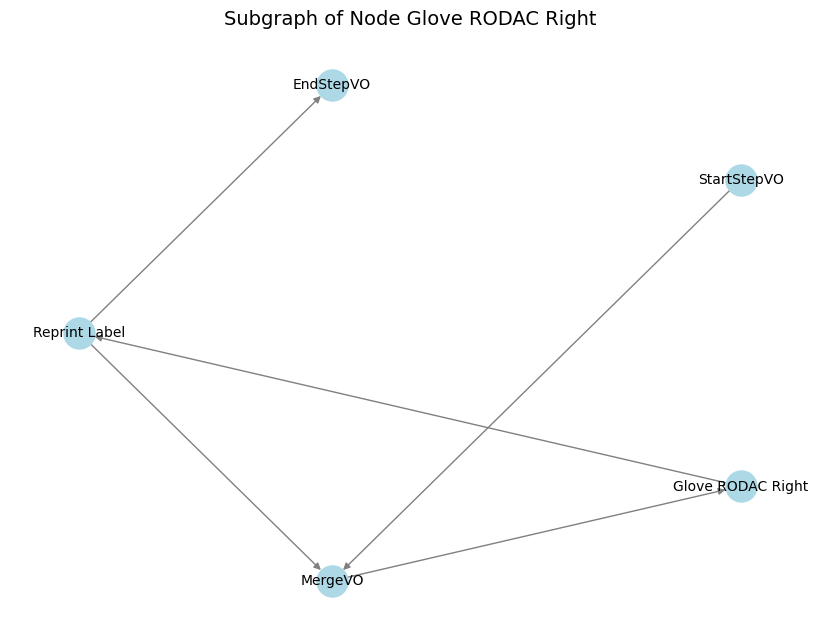

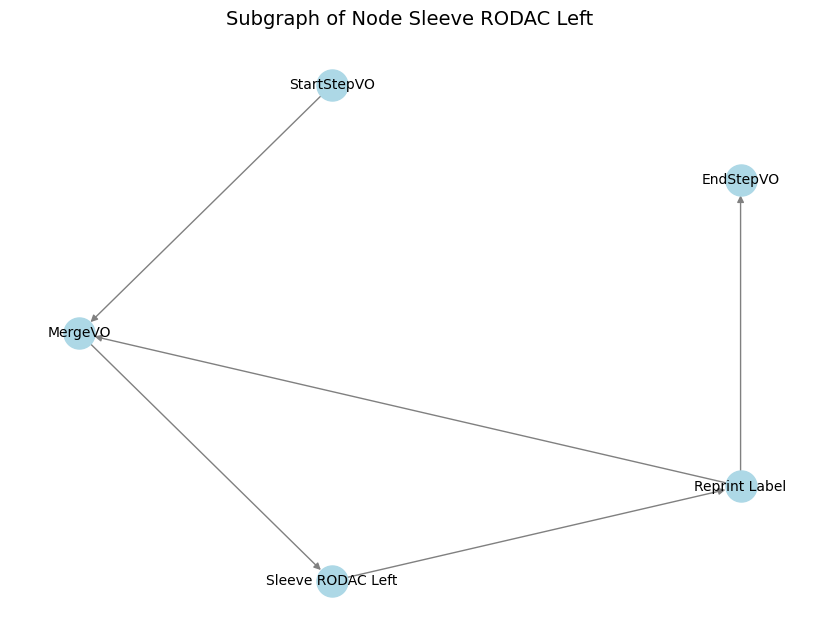

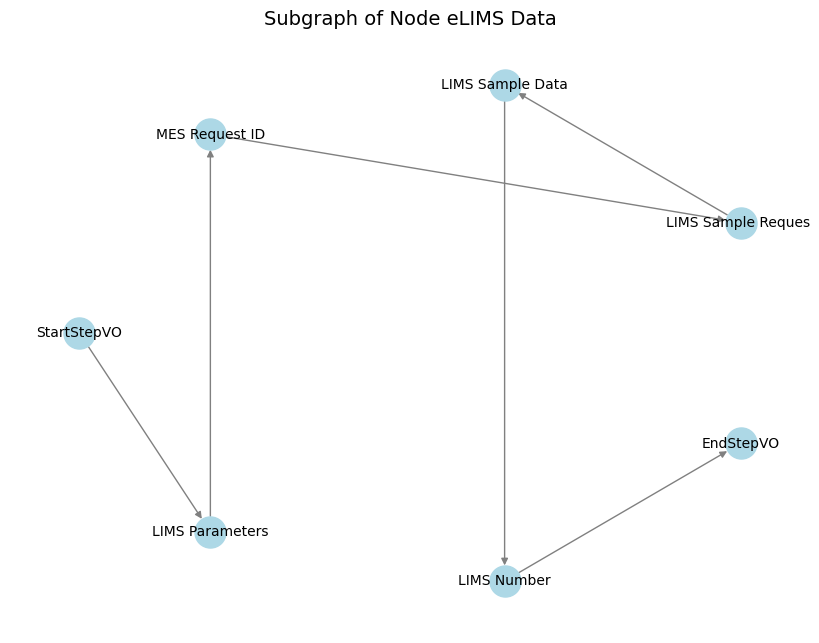

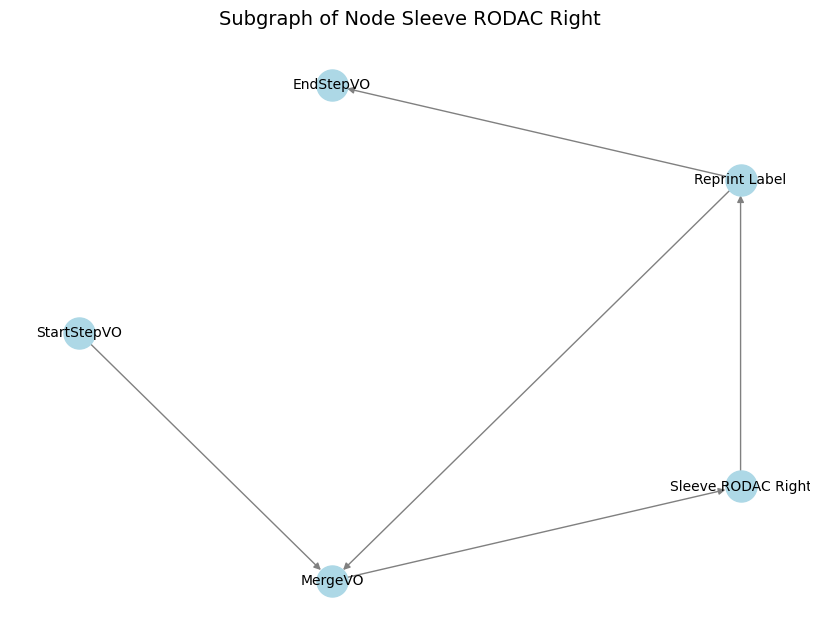

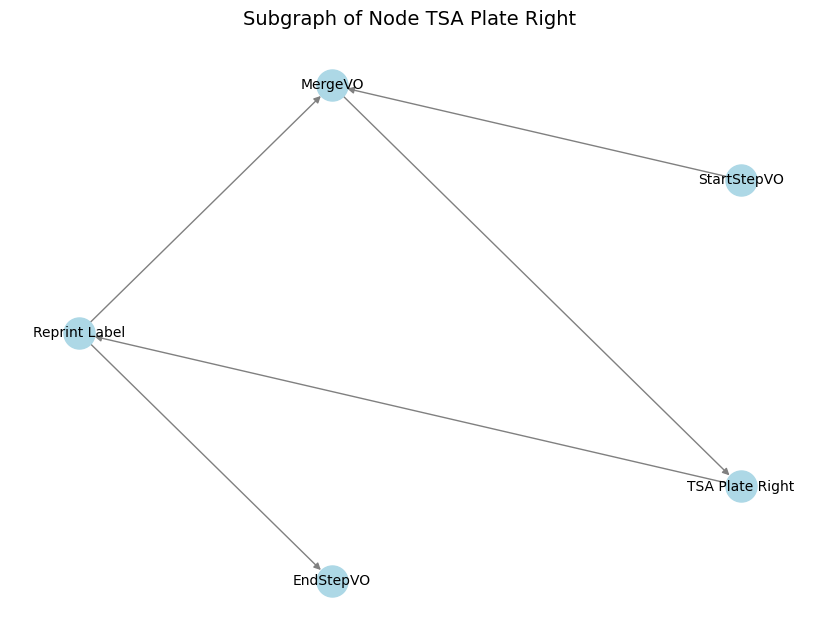

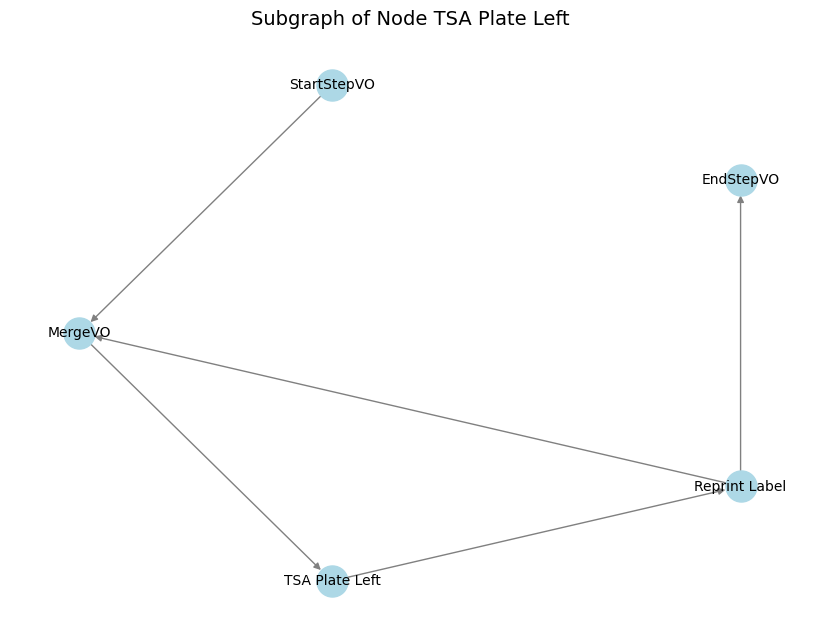

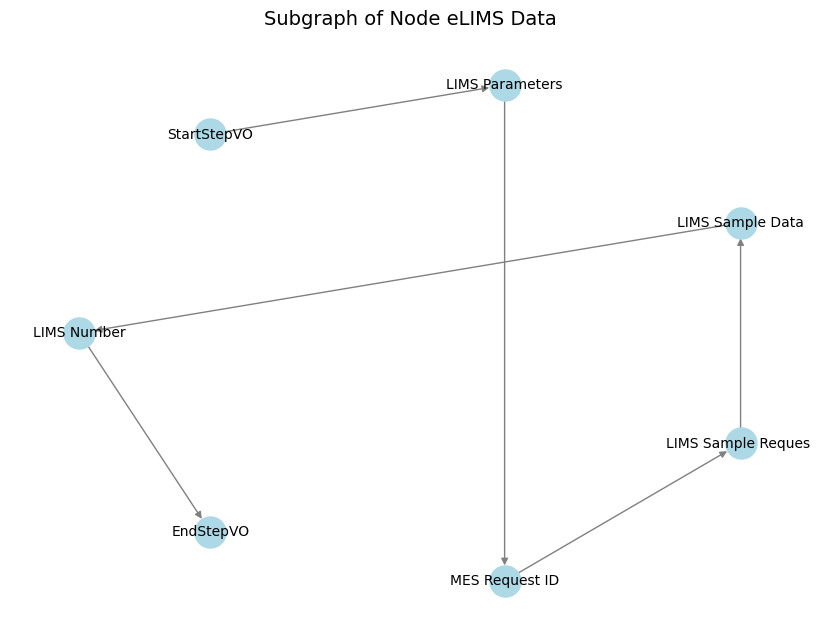

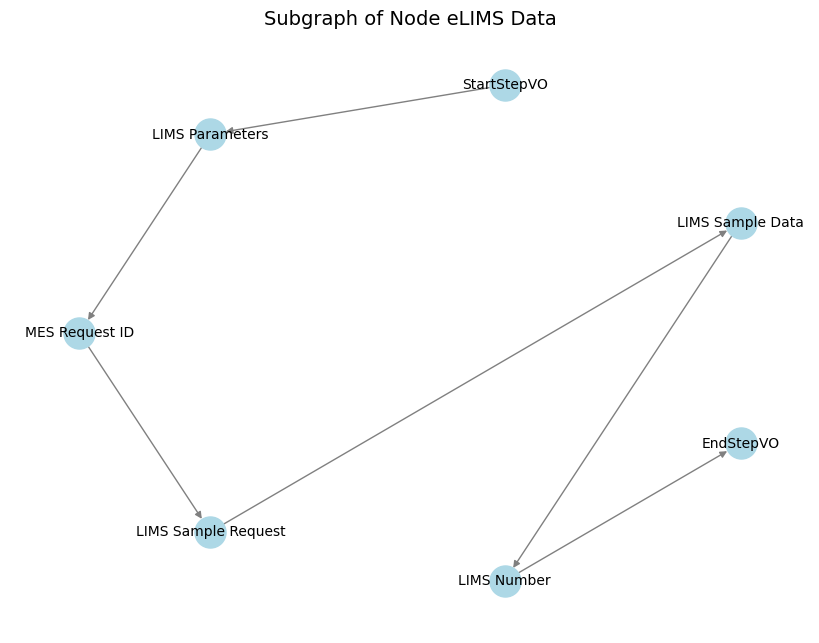

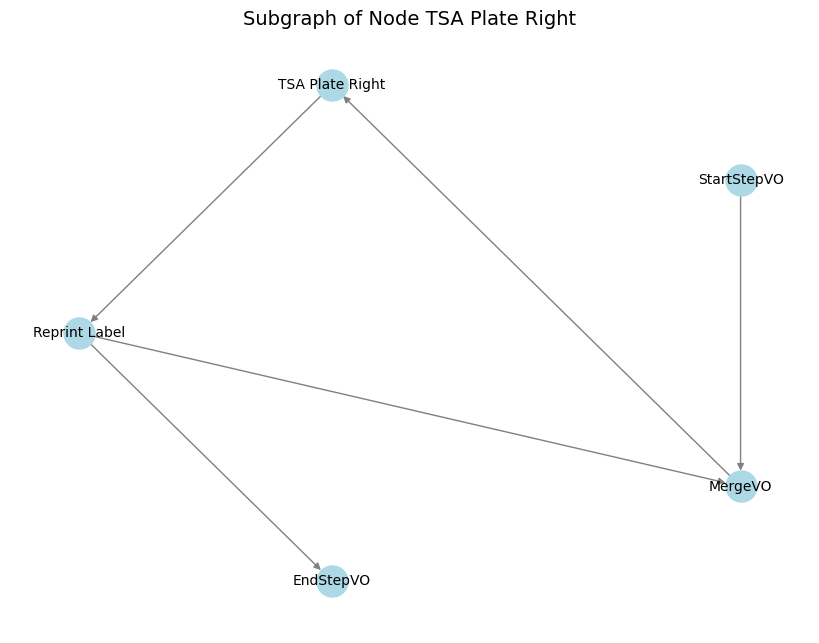

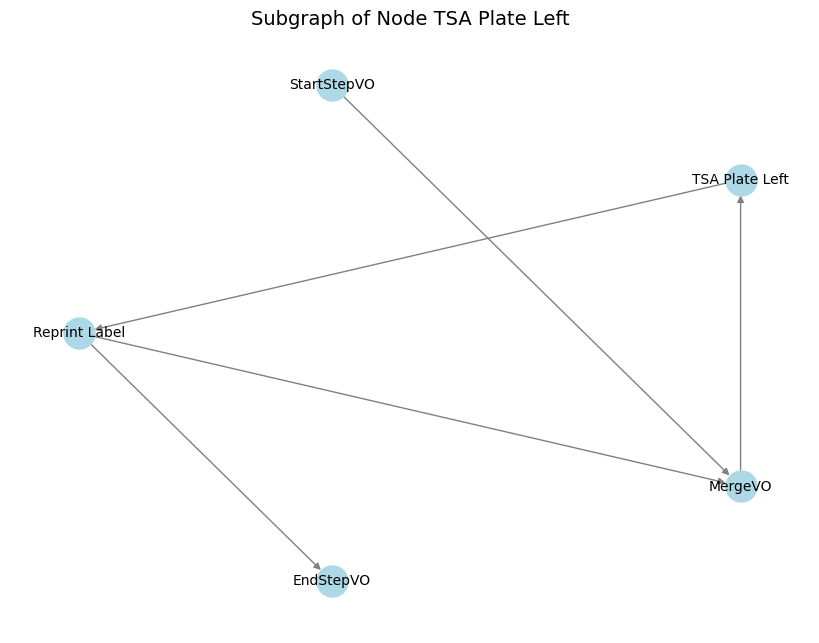

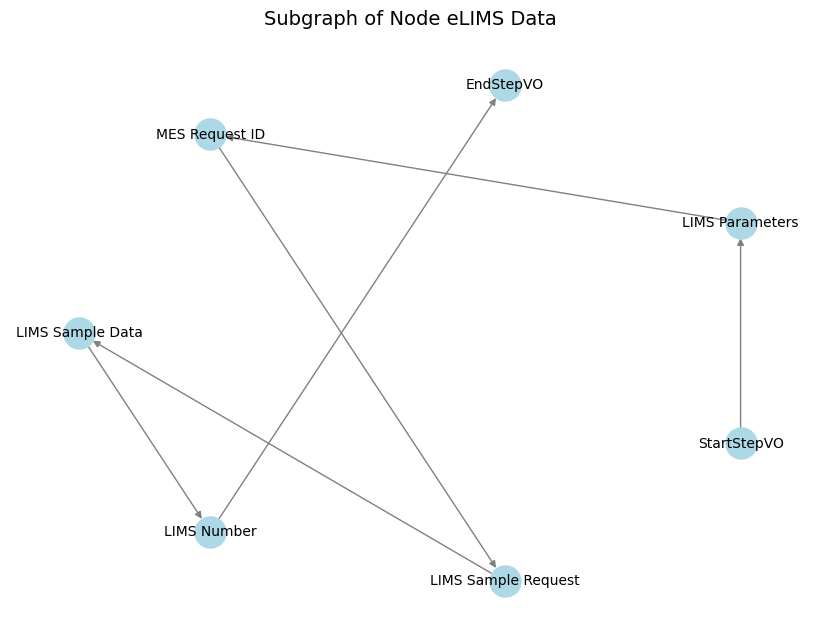

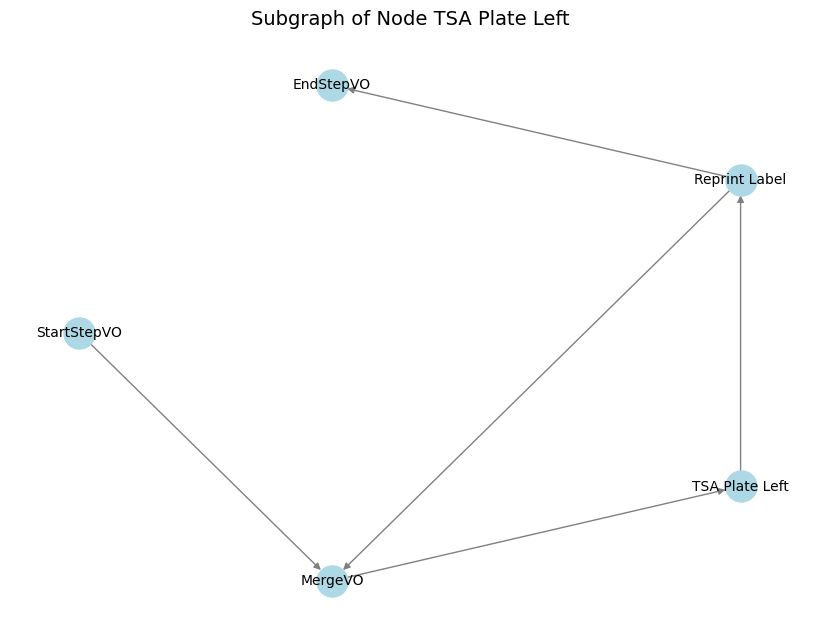

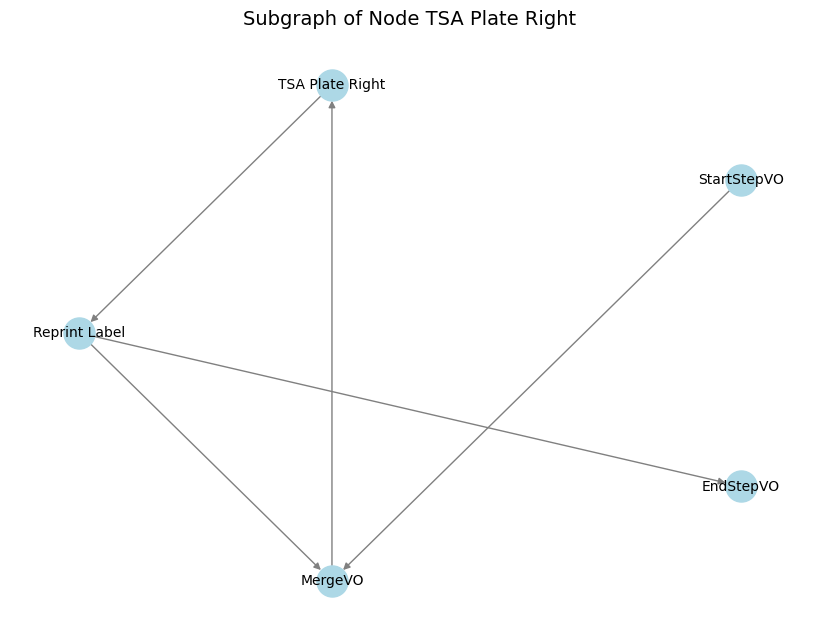

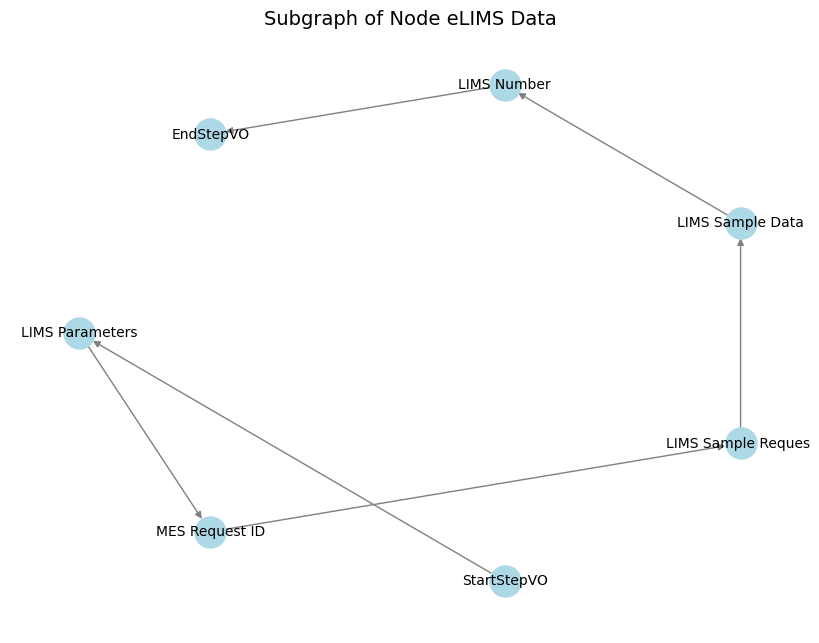

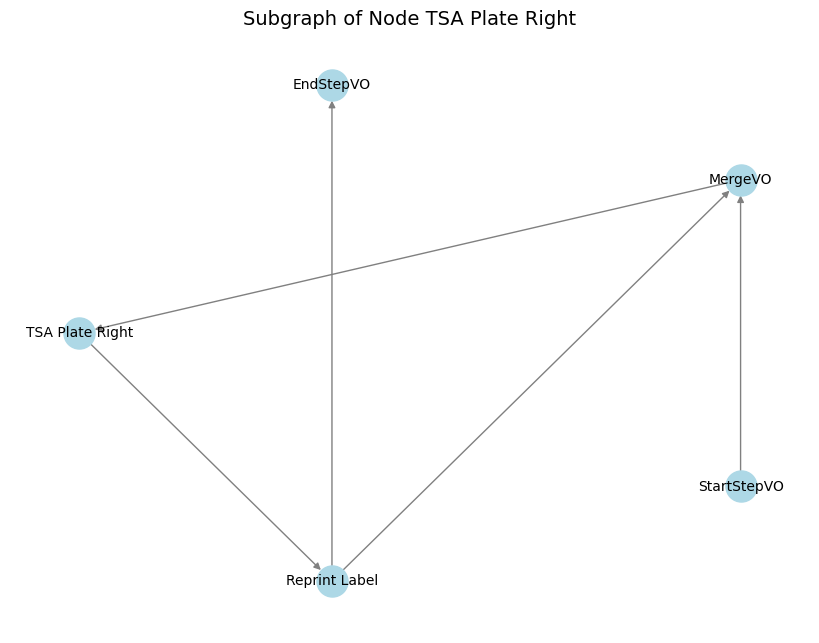

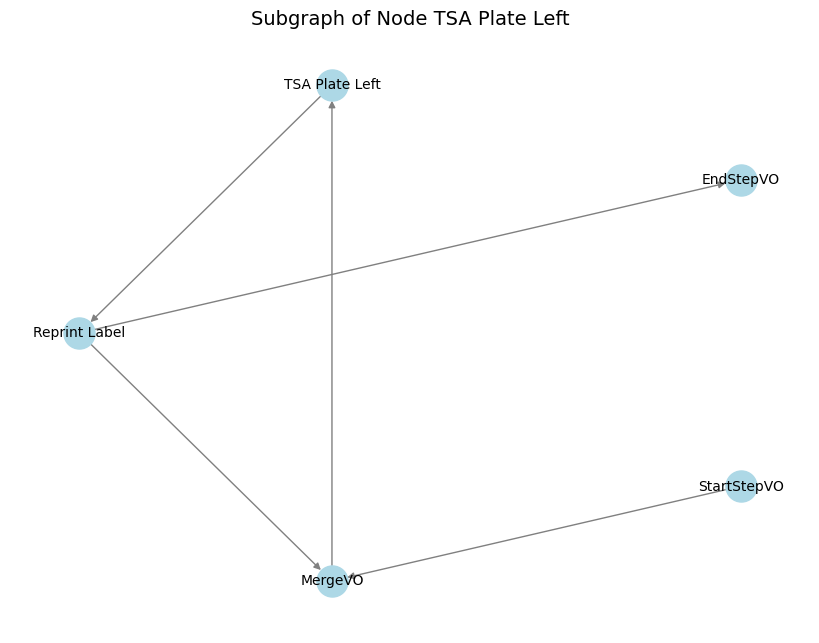

In [86]:
import matplotlib.pyplot as plt
def bfs_visualize_sequentially(graph):
    from networkx.drawing.nx_agraph import graphviz_layout

    """
    Perform BFS on the graph and plot each graph/subgraph in separate figures.
    """
    queue = deque([(graph, "Parent Graph")])  # (current graph, title)
    fig_count = 1

    while queue:
        current_graph, title = queue.popleft()

        # Create a new figure for each graph
        plt.figure(fig_count, figsize=(8, 6))
        fig_count += 1

        labels = {
            node_id: attributes.get('description', str(node_id)) if attributes.get('description', str(node_id)) is not None else attributes.get('type', str(node_id))
            for node_id, attributes in current_graph.nodes(data=True)
        }

        # Calculate layout positions
        try:
            pos = graphviz_layout(current_graph, prog='dot')  # Hierarchical layout
        except ImportError:
            pos = nx.shell_layout(current_graph)  # Fallback layout

        # Draw the current graph
        nx.draw(
            current_graph,
            pos,
            with_labels=True,
            labels=labels,
            node_color='lightblue',
            edge_color='gray',
            node_size=500,
            font_size=10
        )

        # Add a title to the figure
        plt.title(title, fontsize=14)

        # Check for subgraphs and add them to the queue
        for node_id, attributes in current_graph.nodes(data=True):
            subgraph = attributes.get('subgraph')
            node_description = attributes.get('description', f"Node {node_id}")
            if subgraph:
                queue.append((subgraph, f"Subgraph of Node {node_description}"))

    # Show all figures
    plt.show()

bfs_visualize_sequentially(G)
